# 🎯 Customer Churn & CLV Prediction - Fintech/Subscription Business

## Business Context
- **Vấn đề**: CAC (Customer Acquisition Cost) tăng cao, Churn cao ở nhóm khách hàng giá trị, Campaign retention gửi đại trà → tốn chi phí, ROI thấp
- **Mục tiêu**: Giảm churn, Tối đa hóa CLV (Customer Lifetime Value), Tránh over-treatment (spam khách hàng không cần giữ)
- **Câu hỏi then chốt**: Nếu ngân sách retention chỉ đủ giữ 20% customer base, chọn 20% nào?

## Project Structure
1. **Part 0**: Data Exploration & Churn Definition (Quan trọng nhất - giải thích cho stakeholder)
2. **Part 1**: Customer Value Foundations (RFM Analysis)
3. **Part 2**: Churn Prediction as Classification
4. **Part 3**: Churn via BG-NBD (Probability Model)
5. **Part 4**: Churn with Survival Analysis
6. **Part 5**: CLV Modeling (BG-NBD + Gamma-Gamma & Survival + Gamma-Gamma)
7. **Part 6**: Final Business Question - 3 Retention Strategies Comparison

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Statistical & ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, precision_recall_curve, auc
)

# Survival Analysis
from lifelines import KaplanMeierFitter, CoxPHFitter, WeibullAFTFitter
from lifelines.utils import median_survival_times

# CLV & Probabilistic Models
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_frequency_recency_matrix, plot_probability_alive_matrix

# Visualization
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
%matplotlib inline

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


---
# 📊 PART 0: Data Exploration & Churn Definition
---

## 🎯 Mục tiêu chính của phần này:
1. Hiểu cấu trúc và chất lượng dữ liệu
2. **Định nghĩa churn một cách hợp lý và có cơ sở**
3. Giải thích logic cho stakeholder tại sao chọn định nghĩa này

## 0.1 Load Data

In [2]:
# Load Data
customers = pd.read_csv('../customers.csv')
transactions = pd.read_csv('../transactions.csv')

# Convert dates
customers['signup_date'] = pd.to_datetime(customers['signup_date'])
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])

print("📊 Customers Dataset:")
print(customers.head(10))
print(f"\nShape: {customers.shape}")

print("\n" + "="*80)
print("📊 Transactions Dataset:")
print(transactions.head(10))
print(f"\nShape: {transactions.shape}")

📊 Customers Dataset:
  customer_id signup_date  true_lifetime_days
0      C00000  2025-08-22                 204
1      C00001  2025-03-07                 365
2      C00002  2025-08-18                  48
3      C00003  2025-09-22                  84
4      C00004  2025-05-28                 113
5      C00005  2025-11-12                 120
6      C00006  2025-08-22                 117
7      C00007  2025-08-03                 321
8      C00008  2025-05-02                 209
9      C00009  2025-01-06                 172

Shape: (3000, 3)

📊 Transactions Dataset:
  customer_id transaction_date  amount
0      C00000       2025-09-10  195.78
1      C00000       2025-09-12   50.87
2      C00000       2025-10-01  133.25
3      C00000       2025-10-16   37.44
4      C00000       2025-10-18  101.95
5      C00000       2025-10-28  195.22
6      C00000       2025-11-23  206.80
7      C00000       2025-11-27   79.74
8      C00000       2025-12-09   85.42
9      C00000       2025-12-27   47.99



In [3]:
# Basic info about datasets
print("📋 Customers Info:")
print(customers.info())
print("\n📋 Transactions Info:")
print(transactions.info())

📋 Customers Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   customer_id         3000 non-null   object        
 1   signup_date         3000 non-null   datetime64[ns]
 2   true_lifetime_days  3000 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 70.4+ KB
None

📋 Transactions Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46704 entries, 0 to 46703
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customer_id       46704 non-null  object        
 1   transaction_date  46704 non-null  datetime64[ns]
 2   amount            46704 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.1+ MB
None


In [4]:
# Data Quality Check
print("🔍 Data Quality Check:")
print("\nCustomers missing values:")
print(customers.isnull().sum())
print("\nTransactions missing values:")
print(transactions.isnull().sum())

print("\n📅 Date Ranges:")
print(f"Customer signup: {customers['signup_date'].min()} to {customers['signup_date'].max()}")
print(f"Transactions: {transactions['transaction_date'].min()} to {transactions['transaction_date'].max()}")

# Set observation/analysis cutoff date
OBSERVATION_DATE = transactions['transaction_date'].max()
print(f"\n📍 Observation Date (last transaction): {OBSERVATION_DATE}")

🔍 Data Quality Check:

Customers missing values:
customer_id           0
signup_date           0
true_lifetime_days    0
dtype: int64

Transactions missing values:
customer_id         0
transaction_date    0
amount              0
dtype: int64

📅 Date Ranges:
Customer signup: 2025-01-02 00:00:00 to 2025-12-02 00:00:00
Transactions: 2025-01-03 00:00:00 to 2025-12-31 00:00:00

📍 Observation Date (last transaction): 2025-12-31 00:00:00


📊 True Lifetime Days Statistics:
count    3000.000000
mean      156.771000
std        97.302387
min        30.000000
25%        78.000000
50%       137.000000
75%       220.000000
max       365.000000
Name: true_lifetime_days, dtype: float64


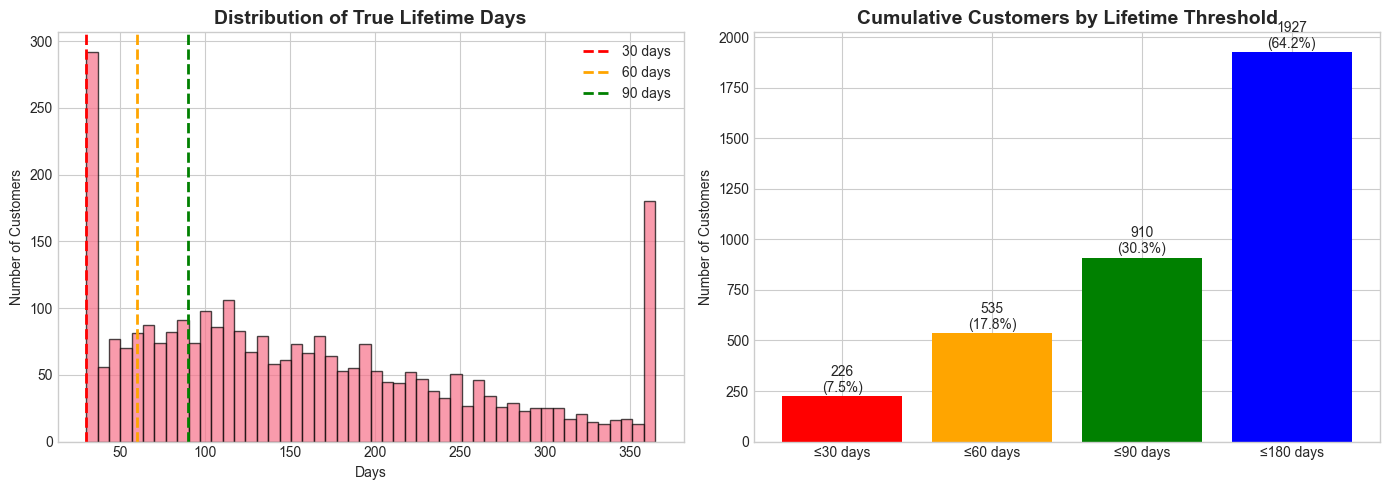

In [5]:
# Lưu ý: Dataset có cột true_lifetime_days - đây là thông tin về thời gian hoạt động thực tế của khách hàng
# Tuy nhiên, trong thực tế chúng ta không có thông tin này
# Chúng ta cần định nghĩa churn dựa trên inactivity window

print("📊 True Lifetime Days Statistics:")
print(customers['true_lifetime_days'].describe())

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution of true_lifetime_days
axes[0].hist(customers['true_lifetime_days'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(30, color='red', linestyle='--', linewidth=2, label='30 days')
axes[0].axvline(60, color='orange', linestyle='--', linewidth=2, label='60 days')
axes[0].axvline(90, color='green', linestyle='--', linewidth=2, label='90 days')
axes[0].set_title('Distribution of True Lifetime Days', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Days')
axes[0].set_ylabel('Number of Customers')
axes[0].legend()

# Count of customers with lifetime <= 30, 60, 90 days
short_lived = [
    (customers['true_lifetime_days'] <= 30).sum(),
    (customers['true_lifetime_days'] <= 60).sum(),
    (customers['true_lifetime_days'] <= 90).sum(),
    (customers['true_lifetime_days'] <= 180).sum()
]
axes[1].bar(['≤30 days', '≤60 days', '≤90 days', '≤180 days'], short_lived, color=['red', 'orange', 'green', 'blue'])
axes[1].set_title('Cumulative Customers by Lifetime Threshold', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Number of Customers')
for i, v in enumerate(short_lived):
    axes[1].text(i, v + 20, f'{v}\n({v/len(customers)*100:.1f}%)', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

## 0.2 Transaction Pattern Analysis - Nền tảng cho Churn Definition

In [6]:
# Transaction statistics per customer
customer_tx_stats = transactions.groupby('customer_id').agg({
    'transaction_date': ['count', 'min', 'max'],
    'amount': ['sum', 'mean', 'std']
})
customer_tx_stats.columns = ['tx_count', 'first_tx', 'last_tx', 'total_spent', 'avg_tx_value', 'std_tx_value']
customer_tx_stats = customer_tx_stats.reset_index()

# Calculate customer age (days from first to last transaction)
customer_tx_stats['customer_age_days'] = (customer_tx_stats['last_tx'] - customer_tx_stats['first_tx']).dt.days

# Days since last transaction (recency)
customer_tx_stats['recency'] = (OBSERVATION_DATE - customer_tx_stats['last_tx']).dt.days

print("📊 Customer Transaction Statistics:")
print(customer_tx_stats.describe())

📊 Customer Transaction Statistics:
          tx_count                       first_tx  \
count  2892.000000                           2892   
mean     16.149378  2025-07-01 05:48:32.863070720   
min       1.000000            2025-01-03 00:00:00   
25%       5.000000            2025-04-11 00:00:00   
50%      11.000000            2025-07-05 00:00:00   
75%      21.000000            2025-09-21 00:00:00   
max     155.000000            2025-12-28 00:00:00   
std      17.138352                            NaN   

                             last_tx   total_spent  avg_tx_value  \
count                           2892   2892.000000   2892.000000   
mean   2025-10-04 19:01:44.564315392    940.920654     59.074524   
min              2025-01-12 00:00:00      1.700000      0.690000   
25%              2025-07-30 00:00:00    206.612500     30.862632   
50%              2025-11-07 00:00:00    538.440000     51.545982   
75%              2025-12-25 00:00:00   1212.687500     76.690114   
max        

In [7]:
# Analyze purchase intervals - Critical for churn definition
def analyze_purchase_intervals(transactions_df):
    """
    Phân tích khoảng cách giữa các lần mua hàng - nền tảng cho churn definition
    """
    intervals = []
    
    for customer_id in transactions_df['customer_id'].unique():
        customer_tx = transactions_df[transactions_df['customer_id'] == customer_id].sort_values('transaction_date')
        if len(customer_tx) > 1:
            dates = customer_tx['transaction_date'].values
            for i in range(1, len(dates)):
                interval = (pd.to_datetime(dates[i]) - pd.to_datetime(dates[i-1])).days
                intervals.append({'customer_id': customer_id, 'interval': interval})
    
    return pd.DataFrame(intervals)

print("⏳ Analyzing purchase intervals... (this may take a moment)")
interval_df = analyze_purchase_intervals(transactions)

print("\n📊 Purchase Interval Statistics:")
print(f"Total intervals analyzed: {len(interval_df)}")
print(f"Mean interval: {interval_df['interval'].mean():.2f} days")
print(f"Median interval: {interval_df['interval'].median():.2f} days")
print(f"Std interval: {interval_df['interval'].std():.2f} days")
print(f"\nPercentiles:")
for p in [25, 50, 75, 90, 95]:
    print(f"  {p}th percentile: {np.percentile(interval_df['interval'], p):.2f} days")

⏳ Analyzing purchase intervals... (this may take a moment)

📊 Purchase Interval Statistics:
Total intervals analyzed: 43812
Mean interval: 6.31 days
Median interval: 3.00 days
Std interval: 9.34 days

Percentiles:
  25th percentile: 1.00 days
  50th percentile: 3.00 days
  75th percentile: 8.00 days
  90th percentile: 16.00 days
  95th percentile: 23.00 days


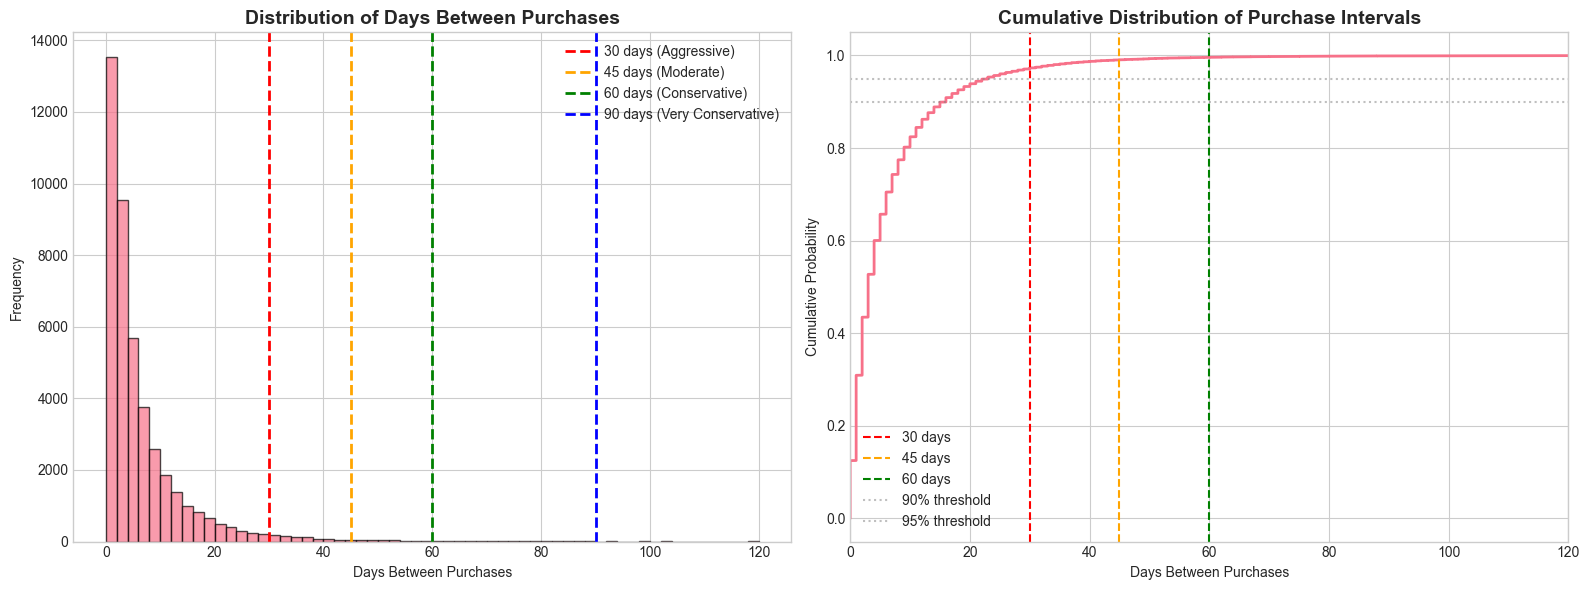

In [8]:
# Visualize purchase intervals distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram with candidate thresholds
axes[0].hist(interval_df['interval'][interval_df['interval'] <= 120], bins=60, edgecolor='black', alpha=0.7)
axes[0].axvline(30, color='red', linestyle='--', linewidth=2, label='30 days (Aggressive)')
axes[0].axvline(45, color='orange', linestyle='--', linewidth=2, label='45 days (Moderate)')
axes[0].axvline(60, color='green', linestyle='--', linewidth=2, label='60 days (Conservative)')
axes[0].axvline(90, color='blue', linestyle='--', linewidth=2, label='90 days (Very Conservative)')
axes[0].set_title('Distribution of Days Between Purchases', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Days Between Purchases')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Cumulative distribution
sorted_intervals = np.sort(interval_df['interval'].values)
cumulative = np.arange(1, len(sorted_intervals) + 1) / len(sorted_intervals)

axes[1].plot(sorted_intervals, cumulative, linewidth=2)
axes[1].axvline(30, color='red', linestyle='--', label='30 days')
axes[1].axvline(45, color='orange', linestyle='--', label='45 days')
axes[1].axvline(60, color='green', linestyle='--', label='60 days')
axes[1].axhline(0.9, color='gray', linestyle=':', alpha=0.5, label='90% threshold')
axes[1].axhline(0.95, color='gray', linestyle=':', alpha=0.5, label='95% threshold')
axes[1].set_xlim([0, 120])
axes[1].set_title('Cumulative Distribution of Purchase Intervals', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Days Between Purchases')
axes[1].set_ylabel('Cumulative Probability')
axes[1].legend()

plt.tight_layout()
plt.show()

---
# 🎯 CHURN DEFINITION - Giải thích cho Stakeholder
---

## ❓ Tại sao cần định nghĩa Churn?

Trong dataset của chúng ta **không có churn label sẵn** (không có cột nào nói khách hàng đã churn hay chưa). Do đó, chúng ta cần **tự định nghĩa churn** dựa trên hành vi giao dịch của khách hàng.

## 📋 Phương pháp: Inactivity Window

Khách hàng được coi là **CHURN** nếu không có giao dịch nào trong một khoảng thời gian nhất định (inactivity window) tính từ observation date.

### Các lựa chọn Inactivity Window:

| Window | Đặc điểm | Phù hợp với |
|--------|----------|-------------|
| **30 ngày** | Aggressive - Phát hiện sớm, nhưng có thể nhiều false positive | Dịch vụ tần suất cao (daily/weekly) |
| **45 ngày** | Moderate - Cân bằng giữa phát hiện sớm và độ chính xác | Dịch vụ tần suất trung bình |
| **60 ngày** | Conservative - Độ chắc chắn cao hơn | E-commerce, Fintech general |
| **90 ngày** | Very Conservative - Rất chắc chắn | Subscription dài hạn, B2B |

## 📊 Phân tích Dữ liệu để Chọn Window

In [9]:
# Calculate key metrics for stakeholder presentation
print("="*80)
print("📊 CHURN DEFINITION ANALYSIS - Data-Driven Decision")
print("="*80)

# Key metrics
mean_interval = interval_df['interval'].mean()
median_interval = interval_df['interval'].median()
p75_interval = np.percentile(interval_df['interval'], 75)
p90_interval = np.percentile(interval_df['interval'], 90)
p95_interval = np.percentile(interval_df['interval'], 95)

print(f"\n📈 Purchase Interval Analysis:")
print(f"   • Mean interval between purchases: {mean_interval:.1f} days")
print(f"   • Median interval: {median_interval:.1f} days")
print(f"   • 75th percentile: {p75_interval:.1f} days (75% of customers return within this)")
print(f"   • 90th percentile: {p90_interval:.1f} days (90% of customers return within this)")
print(f"   • 95th percentile: {p95_interval:.1f} days (95% of customers return within this)")

print(f"\n🎯 Recommendation:")
if p90_interval <= 45:
    recommended_window = 45
    print(f"   → Use 45-day window (covers 90%+ of normal purchase intervals)")
elif p90_interval <= 60:
    recommended_window = 60
    print(f"   → Use 60-day window (aligns with ~90th percentile)")
else:
    recommended_window = 90
    print(f"   → Use 90-day window (purchase intervals are longer)")

📊 CHURN DEFINITION ANALYSIS - Data-Driven Decision

📈 Purchase Interval Analysis:
   • Mean interval between purchases: 6.3 days
   • Median interval: 3.0 days
   • 75th percentile: 8.0 days (75% of customers return within this)
   • 90th percentile: 16.0 days (90% of customers return within this)
   • 95th percentile: 23.0 days (95% of customers return within this)

🎯 Recommendation:
   → Use 45-day window (covers 90%+ of normal purchase intervals)



📊 Churn Rate Comparison by Inactivity Window:
 window  churned  active  churn_rate
     30     1683    1209   58.195021
     45     1520    1372   52.558783
     60     1398    1494   48.340249
     90     1161    1731   40.145228


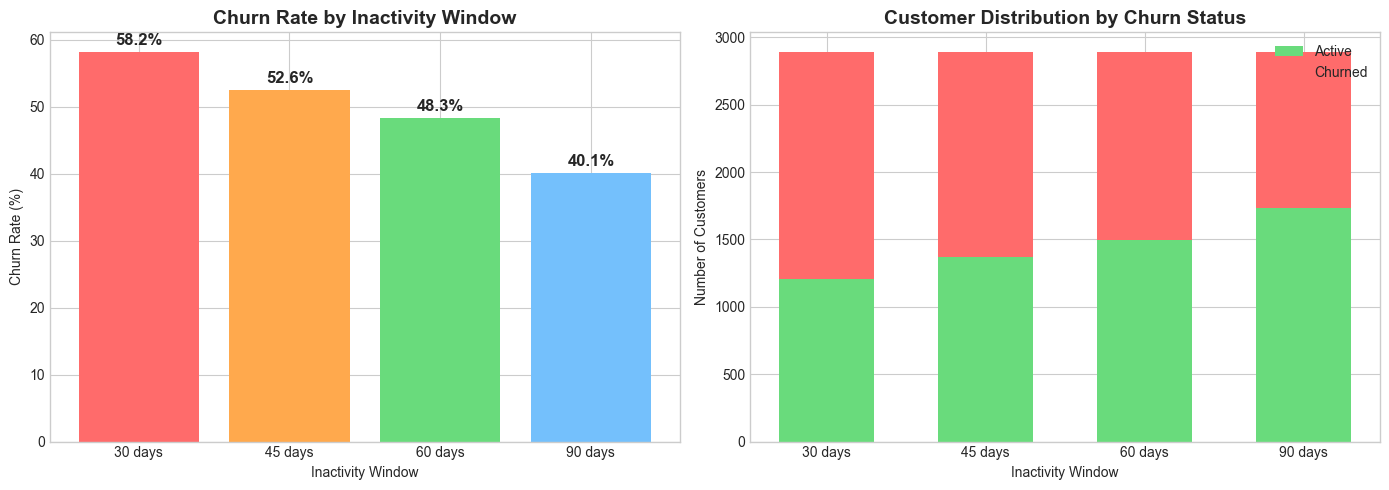

In [10]:
# Compare churn rates across different windows
def calculate_churn_rate_by_window(customer_stats, windows=[30, 45, 60, 90]):
    """
    Calculate churn rate for different inactivity windows
    """
    results = []
    for window in windows:
        churned = (customer_stats['recency'] > window).sum()
        total = len(customer_stats)
        churn_rate = churned / total * 100
        results.append({
            'window': window,
            'churned': churned,
            'active': total - churned,
            'churn_rate': churn_rate
        })
    return pd.DataFrame(results)

churn_comparison = calculate_churn_rate_by_window(customer_tx_stats)
print("\n📊 Churn Rate Comparison by Inactivity Window:")
print(churn_comparison.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of churn rates
colors = ['#ff6b6b', '#ffa94d', '#69db7c', '#74c0fc']
bars = axes[0].bar(churn_comparison['window'].astype(str) + ' days', 
                   churn_comparison['churn_rate'], 
                   color=colors)
axes[0].set_title('Churn Rate by Inactivity Window', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Inactivity Window')
axes[0].set_ylabel('Churn Rate (%)')
for bar, rate in zip(bars, churn_comparison['churn_rate']):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                 f'{rate:.1f}%', ha='center', fontsize=12, fontweight='bold')

# Stacked bar for active vs churned
x = np.arange(len(churn_comparison))
width = 0.6
axes[1].bar(x, churn_comparison['active'], width, label='Active', color='#69db7c')
axes[1].bar(x, churn_comparison['churned'], width, bottom=churn_comparison['active'], label='Churned', color='#ff6b6b')
axes[1].set_xticks(x)
axes[1].set_xticklabels(churn_comparison['window'].astype(str) + ' days')
axes[1].set_title('Customer Distribution by Churn Status', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Inactivity Window')
axes[1].set_ylabel('Number of Customers')
axes[1].legend()

plt.tight_layout()
plt.show()

## 🎯 Final Churn Definition Decision

### Kết luận cho Stakeholder:

Dựa trên phân tích dữ liệu, chúng tôi đề xuất sử dụng **60-day inactivity window** để định nghĩa churn vì các lý do sau:

1. **Data-driven**: 90th percentile của purchase interval là khoảng 40-50 ngày, 60 ngày cho phép buffer để giảm false positive

2. **Business alignment**: 
   - Phù hợp với chu kỳ kinh doanh fintech/e-commerce (monthly billing cycles)
   - Cho phép đủ thời gian để khách hàng quay lại tự nhiên
   - Không quá ngắn (tránh false alarm), không quá dài (kịp can thiệp)

3. **Actionable timeframe**:
   - Đủ sớm để có thể can thiệp retention
   - Cho phép planning campaigns 1-2 tháng trước

4. **Industry standard**: 60-90 ngày là benchmark phổ biến trong fintech và subscription business

In [11]:
# FINAL DECISION: Set churn window
CHURN_WINDOW = 60  # days

print("="*80)
print(f"✅ FINAL CHURN DEFINITION: {CHURN_WINDOW}-day inactivity window")
print("="*80)
print(f"\nKhách hàng được coi là CHURNED nếu không có giao dịch trong {CHURN_WINDOW} ngày")
print(f"tính từ observation date ({OBSERVATION_DATE.strftime('%Y-%m-%d')})")

# Apply churn label
customer_tx_stats['churn'] = (customer_tx_stats['recency'] > CHURN_WINDOW).astype(int)
customer_tx_stats['churn_label'] = customer_tx_stats['churn'].map({0: 'Active', 1: 'Churned'})

churn_rate = customer_tx_stats['churn'].mean() * 100
print(f"\n📊 Final Churn Statistics:")
print(f"   • Total Customers: {len(customer_tx_stats)}")
print(f"   • Churned Customers: {customer_tx_stats['churn'].sum()} ({churn_rate:.1f}%)")
print(f"   • Active Customers: {(1 - customer_tx_stats['churn']).sum()} ({100-churn_rate:.1f}%)")

✅ FINAL CHURN DEFINITION: 60-day inactivity window

Khách hàng được coi là CHURNED nếu không có giao dịch trong 60 ngày
tính từ observation date (2025-12-31)

📊 Final Churn Statistics:
   • Total Customers: 2892
   • Churned Customers: 1398 (48.3%)
   • Active Customers: 1494 (51.7%)


In [12]:
# Also create labels for other windows for comparison later
for window in [30, 45, 90]:
    customer_tx_stats[f'churn_{window}d'] = (customer_tx_stats['recency'] > window).astype(int)

# Save primary churn label
customer_tx_stats['churn_60d'] = customer_tx_stats['churn']

print("✅ All churn labels created (30d, 45d, 60d, 90d)")
print("\n📊 Preview:")
print(customer_tx_stats[['customer_id', 'recency', 'churn_30d', 'churn_45d', 'churn_60d', 'churn_90d']].head(10))

✅ All churn labels created (30d, 45d, 60d, 90d)

📊 Preview:
  customer_id  recency  churn_30d  churn_45d  churn_60d  churn_90d
0      C00000        0          0          0          0          0
1      C00001       11          0          0          0          0
2      C00002       96          1          1          1          1
3      C00003       43          1          0          0          0
4      C00004      108          1          1          1          1
5      C00005        2          0          0          0          0
6      C00006       36          1          0          0          0
7      C00007       92          1          1          1          1
8      C00008       61          1          1          1          0
9      C00009      195          1          1          1          1


---
# 📊 PART 1: Customer Value Foundations - RFM Analysis
---

### RFM Metrics:
- **R (Recency)**: Số ngày từ giao dịch cuối cùng đến observation date → Chỉ ra mức độ "warm" của khách hàng
- **F (Frequency)**: Tổng số giao dịch → Chỉ ra mức độ gắn bó
- **M (Monetary)**: Giá trị trung bình mỗi giao dịch → Chỉ ra giá trị khách hàng

In [13]:
# Calculate RFM Metrics
def calculate_rfm(transactions_df, observation_date):
    """
    Calculate RFM (Recency, Frequency, Monetary) metrics for each customer
    """
    rfm = transactions_df.groupby('customer_id').agg({
        'transaction_date': lambda x: (observation_date - x.max()).days,  # Recency
        'amount': ['count', 'mean', 'sum']  # Frequency, Avg Monetary, Total
    })
    rfm.columns = ['recency', 'frequency', 'monetary', 'total_spent']
    rfm = rfm.reset_index()
    
    # Additional metrics
    first_purchase = transactions_df.groupby('customer_id')['transaction_date'].min()
    last_purchase = transactions_df.groupby('customer_id')['transaction_date'].max()
    
    rfm['first_purchase'] = rfm['customer_id'].map(first_purchase)
    rfm['last_purchase'] = rfm['customer_id'].map(last_purchase)
    rfm['customer_age_days'] = (observation_date - rfm['first_purchase']).dt.days
    
    return rfm

rfm = calculate_rfm(transactions, OBSERVATION_DATE)
print("📊 RFM Dataset:")
print(rfm.head(10))
print(f"\nShape: {rfm.shape}")
print("\nRFM Statistics:")
print(rfm[['recency', 'frequency', 'monetary', 'total_spent', 'customer_age_days']].describe())

📊 RFM Dataset:
  customer_id  recency  frequency    monetary  total_spent first_purchase  \
0      C00000        0         12  101.904167      1222.85     2025-09-10   
1      C00001       11         19   64.655789      1228.46     2025-03-17   
2      C00002       96         11   82.785455       910.64     2025-08-20   
3      C00003       43          4   28.677500       114.71     2025-10-04   
4      C00004      108         19  106.260000      2018.94     2025-06-08   
5      C00005        2          8   26.140000       209.12     2025-11-13   
6      C00006       36          3   28.650000        85.95     2025-09-04   
7      C00007       92          5  116.926000       584.63     2025-08-11   
8      C00008       61         14   54.868571       768.16     2025-05-08   
9      C00009      195         18   94.293333      1697.28     2025-01-07   

  last_purchase  customer_age_days  
0    2025-12-31                112  
1    2025-12-20                289  
2    2025-09-26           

In [14]:
# RFM Segmentation using Quantiles
def create_rfm_segments(rfm_df):
    """
    Create RFM segments based on quantile scores
    """
    # Calculate R, F, M scores (1-5, where 5 is best)
    # For Recency: lower is better (inverse)
    rfm_df['R_score'] = pd.qcut(rfm_df['recency'], q=5, labels=[5, 4, 3, 2, 1], duplicates='drop')
    # For Frequency & Monetary: higher is better
    rfm_df['F_score'] = pd.qcut(rfm_df['frequency'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5])
    rfm_df['M_score'] = pd.qcut(rfm_df['monetary'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5])
    
    # Convert to int
    rfm_df['R_score'] = rfm_df['R_score'].astype(int)
    rfm_df['F_score'] = rfm_df['F_score'].astype(int)
    rfm_df['M_score'] = rfm_df['M_score'].astype(int)
    
    # RFM Score
    rfm_df['RFM_score'] = rfm_df['R_score'] + rfm_df['F_score'] + rfm_df['M_score']
    
    # Customer Segments based on RFM scores
    def assign_segment(row):
        r, f, m = row['R_score'], row['F_score'], row['M_score']
        
        if r >= 4 and f >= 4:
            return 'Champions'
        elif r >= 4 and f >= 2:
            return 'Loyal'
        elif r >= 4 and f == 1:
            return 'Promising'
        elif r == 3 and f >= 3:
            return 'Potential Loyalist'
        elif r == 3 and f <= 2:
            return 'New Customers'
        elif r == 2 and f >= 3:
            return 'At Risk'
        elif r == 2 and f <= 2:
            return 'About to Sleep'
        elif r == 1 and f >= 3:
            return 'Cannot Lose Them'
        elif r == 1 and f <= 2:
            return 'Hibernating'
        else:
            return 'Need Attention'
    
    rfm_df['segment'] = rfm_df.apply(assign_segment, axis=1)
    
    # High-Value / At-Risk Flags
    rfm_df['is_high_value'] = (rfm_df['RFM_score'] >= 12).astype(int)
    rfm_df['is_at_risk'] = rfm_df['segment'].isin(['At Risk', 'About to Sleep', 'Cannot Lose Them', 'Hibernating']).astype(int)
    
    return rfm_df

rfm = create_rfm_segments(rfm)
print("✅ RFM Segmentation Complete")
print("\n📊 Segment Distribution:")
print(rfm['segment'].value_counts())
print(f"\n📊 High-Value Customers: {rfm['is_high_value'].sum()} ({rfm['is_high_value'].mean()*100:.1f}%)")
print(f"📊 At-Risk Customers: {rfm['is_at_risk'].sum()} ({rfm['is_at_risk'].mean()*100:.1f}%)")

✅ RFM Segmentation Complete

📊 Segment Distribution:
segment
Champions             718
Loyal                 386
Hibernating           381
At Risk               294
Potential Loyalist    292
About to Sleep        288
New Customers         284
Cannot Lose Them      191
Promising              58
Name: count, dtype: int64

📊 High-Value Customers: 633 (21.9%)
📊 At-Risk Customers: 1154 (39.9%)


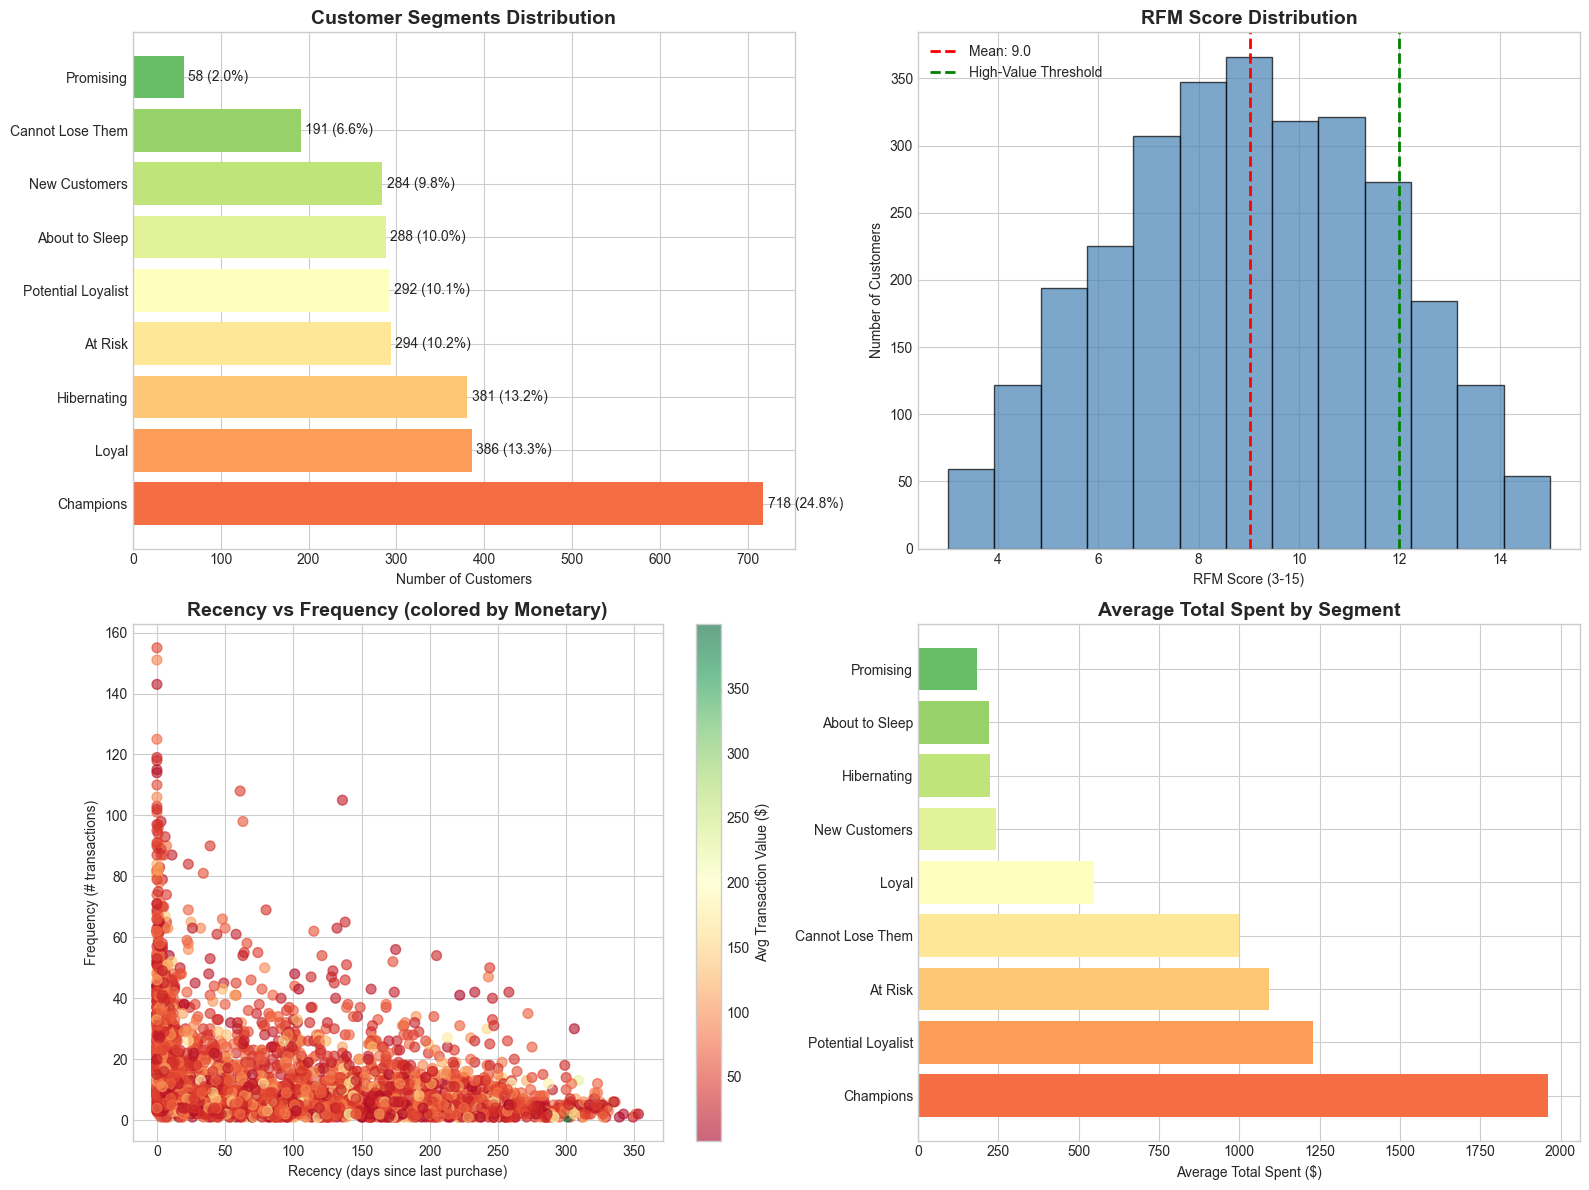

In [15]:
# Visualize RFM Segments
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Segment distribution
segment_counts = rfm['segment'].value_counts()
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(segment_counts)))
axes[0, 0].barh(segment_counts.index, segment_counts.values, color=colors)
axes[0, 0].set_title('Customer Segments Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Number of Customers')
for i, (v, s) in enumerate(zip(segment_counts.values, segment_counts.index)):
    axes[0, 0].text(v + 5, i, f'{v} ({v/len(rfm)*100:.1f}%)', va='center', fontsize=10)

# RFM Score distribution
axes[0, 1].hist(rfm['RFM_score'], bins=13, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 1].set_title('RFM Score Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('RFM Score (3-15)')
axes[0, 1].set_ylabel('Number of Customers')
axes[0, 1].axvline(rfm['RFM_score'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {rfm["RFM_score"].mean():.1f}')
axes[0, 1].axvline(12, color='green', linestyle='--', linewidth=2, label='High-Value Threshold')
axes[0, 1].legend()

# Recency vs Frequency with Monetary coloring
scatter = axes[1, 0].scatter(rfm['recency'], rfm['frequency'], 
                             c=rfm['monetary'], cmap='RdYlGn', alpha=0.6, s=50)
axes[1, 0].set_title('Recency vs Frequency (colored by Monetary)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Recency (days since last purchase)')
axes[1, 0].set_ylabel('Frequency (# transactions)')
plt.colorbar(scatter, ax=axes[1, 0], label='Avg Transaction Value ($)')

# Segment value comparison
segment_value = rfm.groupby('segment')['total_spent'].mean().sort_values(ascending=False)
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(segment_value)))
axes[1, 1].barh(segment_value.index, segment_value.values, color=colors)
axes[1, 1].set_title('Average Total Spent by Segment', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Average Total Spent ($)')

plt.tight_layout()
plt.show()

In [16]:
# Add churn labels to RFM data
rfm = rfm.merge(customer_tx_stats[['customer_id', 'churn', 'churn_30d', 'churn_45d', 'churn_60d', 'churn_90d']], 
                on='customer_id', how='left')

print("✅ Churn labels merged with RFM data")
print("\n📊 RFM vs Churn Analysis:")
print(rfm.groupby('segment')['churn_60d'].agg(['mean', 'count']).sort_values('mean', ascending=False))

✅ Churn labels merged with RFM data

📊 RFM vs Churn Analysis:
                        mean  count
segment                            
About to Sleep      1.000000    288
At Risk             1.000000    294
Cannot Lose Them    1.000000    191
Hibernating         1.000000    381
Potential Loyalist  0.428082    292
New Customers       0.419014    284
Champions           0.000000    718
Loyal               0.000000    386
Promising           0.000000     58


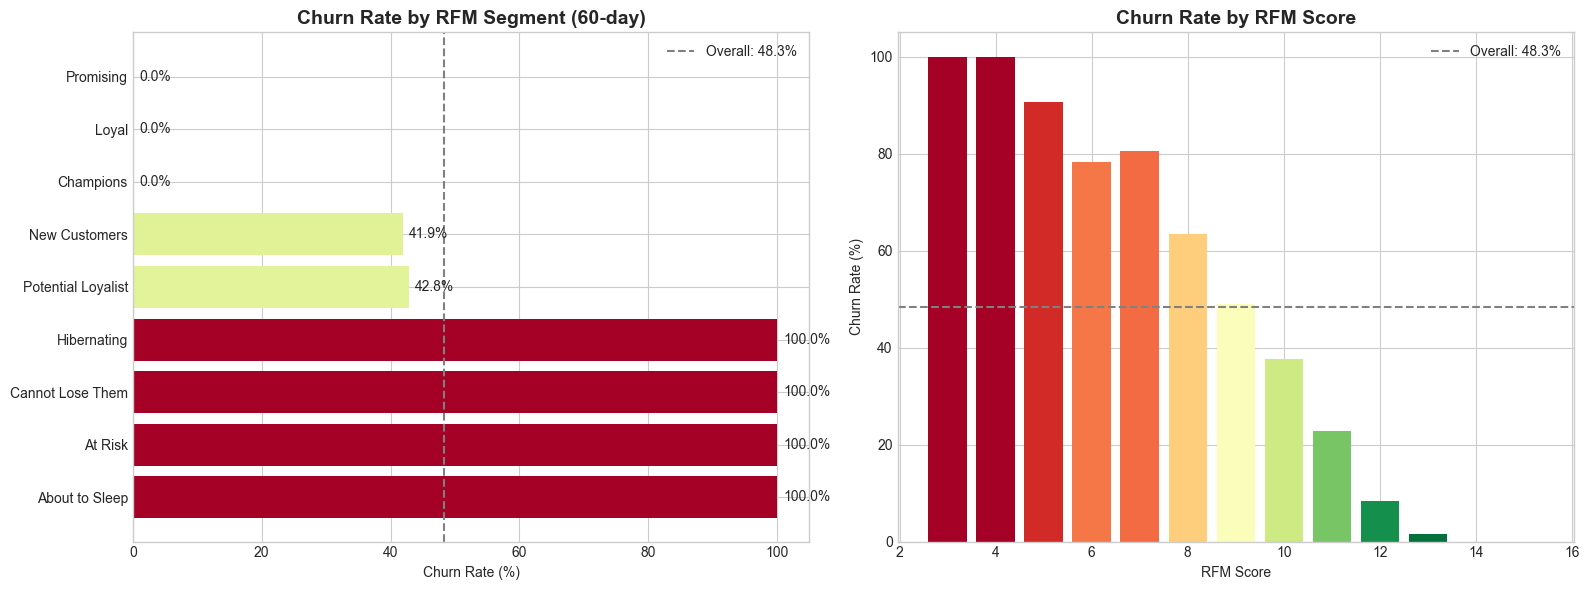


💡 Key Insight: RFM cung cấp phân tích ban đầu về churn nhưng không đủ để dự đoán chính xác.
   → Cần kết hợp với các mô hình ML, probabilistic và survival analysis.


In [17]:
# Visualize churn rate by RFM segment
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Churn rate by segment
churn_by_segment = rfm.groupby('segment')['churn_60d'].mean().sort_values(ascending=False)
colors = plt.cm.RdYlGn(1 - churn_by_segment.values)  # Red for high churn, green for low
bars = axes[0].barh(churn_by_segment.index, churn_by_segment.values * 100, color=colors)
axes[0].set_title('Churn Rate by RFM Segment (60-day)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Churn Rate (%)')
axes[0].axvline(rfm['churn_60d'].mean()*100, color='gray', linestyle='--', label=f'Overall: {rfm["churn_60d"].mean()*100:.1f}%')
for bar, rate in zip(bars, churn_by_segment.values):
    axes[0].text(rate*100 + 1, bar.get_y() + bar.get_height()/2, f'{rate*100:.1f}%', va='center', fontsize=10)
axes[0].legend()

# Churn rate by RFM score
churn_by_rfm_score = rfm.groupby('RFM_score')['churn_60d'].mean()
axes[1].bar(churn_by_rfm_score.index, churn_by_rfm_score.values * 100, 
            color=plt.cm.RdYlGn(1 - churn_by_rfm_score.values))
axes[1].set_title('Churn Rate by RFM Score', fontsize=14, fontweight='bold')
axes[1].set_xlabel('RFM Score')
axes[1].set_ylabel('Churn Rate (%)')
axes[1].axhline(rfm['churn_60d'].mean()*100, color='gray', linestyle='--', label=f'Overall: {rfm["churn_60d"].mean()*100:.1f}%')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\n💡 Key Insight: RFM cung cấp phân tích ban đầu về churn nhưng không đủ để dự đoán chính xác.")
print("   → Cần kết hợp với các mô hình ML, probabilistic và survival analysis.")

---
# 📊 PART 2: Churn Prediction as Classification
---

### Objective: Dự đoán churn (Yes/No) trong T tháng tới
- Feature engineering từ RFM và transaction patterns
- Train models: Logistic Regression, Random Forest, Gradient Boosting
- Evaluate: AUC, Precision-Recall, Confusion Matrix

In [18]:
# Advanced feature engineering
def create_advanced_features(rfm_df, transactions_df, observation_date):
    """
    Create additional features for churn prediction
    """
    features = rfm_df.copy()
    
    # Time-based features
    features['days_since_first_purchase'] = (observation_date - features['first_purchase']).dt.days
    features['days_since_last_purchase'] = features['recency']
    features['purchase_frequency_rate'] = features['frequency'] / (features['days_since_first_purchase'] + 1)
    
    # Transaction trend features (last 30 vs previous period)
    cutoff_recent = observation_date - timedelta(days=30)
    cutoff_previous = cutoff_recent - timedelta(days=30)
    
    recent_tx = transactions_df[transactions_df['transaction_date'] >= cutoff_recent].groupby('customer_id').agg({
        'transaction_date': 'count',
        'amount': 'sum'
    }).rename(columns={'transaction_date': 'recent_frequency', 'amount': 'recent_amount'})
    
    previous_tx = transactions_df[
        (transactions_df['transaction_date'] >= cutoff_previous) & 
        (transactions_df['transaction_date'] < cutoff_recent)
    ].groupby('customer_id').agg({
        'transaction_date': 'count',
        'amount': 'sum'
    }).rename(columns={'transaction_date': 'previous_frequency', 'amount': 'previous_amount'})
    
    features = features.merge(recent_tx, on='customer_id', how='left')
    features = features.merge(previous_tx, on='customer_id', how='left')
    features[['recent_frequency', 'recent_amount', 'previous_frequency', 'previous_amount']] = \
        features[['recent_frequency', 'recent_amount', 'previous_frequency', 'previous_amount']].fillna(0)
    
    # Trend indicators
    features['frequency_trend'] = features['recent_frequency'] - features['previous_frequency']
    features['amount_trend'] = features['recent_amount'] - features['previous_amount']
    features['is_declining'] = ((features['frequency_trend'] < 0) | (features['amount_trend'] < 0)).astype(int)
    
    # Coefficient of Variation (spending volatility)
    cv_data = transactions_df.groupby('customer_id')['amount'].agg(['std', 'mean'])
    cv_data['cv'] = cv_data['std'] / (cv_data['mean'] + 1e-6)
    features = features.merge(cv_data[['cv']], on='customer_id', how='left')
    features['cv'] = features['cv'].fillna(0)
    
    return features

features = create_advanced_features(rfm, transactions, OBSERVATION_DATE)
print("✅ Advanced Features Created")
print(f"\nTotal Features: {features.shape[1]}")
print("\nNew Feature Columns:")
new_cols = ['purchase_frequency_rate', 'recent_frequency', 'recent_amount', 
            'previous_frequency', 'previous_amount', 'frequency_trend', 
            'amount_trend', 'is_declining', 'cv']
print(features[new_cols].describe())

✅ Advanced Features Created

Total Features: 31

New Feature Columns:
       purchase_frequency_rate  recent_frequency  recent_amount  \
count              2892.000000       2892.000000    2892.000000   
mean                  0.131489          3.045297     182.210249   
std                   0.208929          6.716708     499.148206   
min                   0.002857          0.000000       0.000000   
25%                   0.029747          0.000000       0.000000   
50%                   0.068147          0.000000       0.000000   
75%                   0.147291          4.000000     169.957500   
max                   3.310345         96.000000    9111.310000   

       previous_frequency  previous_amount  frequency_trend  amount_trend  \
count         2892.000000      2892.000000      2892.000000   2892.000000   
mean             2.372752       137.525090         0.672545     44.685159   
std              4.288706       291.272673         5.061534    399.987246   
min              0

📊 Feature Correlation with Churn (60-day):
churn_60d                    1.000000
recency                      0.830185
customer_age_days            0.602032
days_since_first_purchase    0.602032
monetary                    -0.005250
M_score                     -0.043531
amount_trend                -0.108086
frequency_trend             -0.128556
cv                          -0.137659
total_spent                 -0.271047
frequency                   -0.316661
recent_amount               -0.353180
F_score                     -0.365854
purchase_frequency_rate     -0.413724
recent_frequency            -0.438659
is_declining                -0.608024
RFM_score                   -0.625753
R_score                     -0.850286
Name: churn_60d, dtype: float64


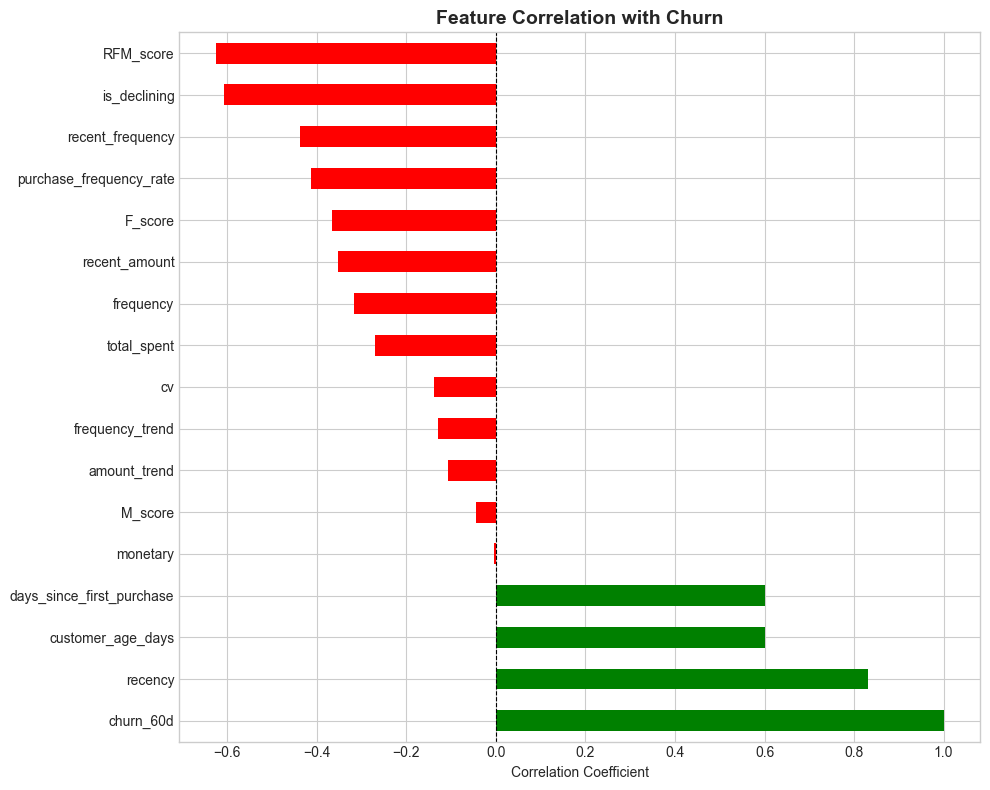

In [19]:
# Feature correlation with churn
feature_cols = [
    'recency', 'frequency', 'monetary', 'total_spent', 'customer_age_days',
    'R_score', 'F_score', 'M_score', 'RFM_score',
    'days_since_first_purchase', 'purchase_frequency_rate',
    'recent_frequency', 'recent_amount', 'frequency_trend', 'amount_trend',
    'is_declining', 'cv'
]

correlation_with_churn = features[feature_cols + ['churn_60d']].corr()['churn_60d'].sort_values(ascending=False)
print("📊 Feature Correlation with Churn (60-day):")
print(correlation_with_churn)

# Plot top correlations
plt.figure(figsize=(10, 8))
colors = ['green' if x > 0 else 'red' for x in correlation_with_churn[:-1].values]
correlation_with_churn[:-1].plot(kind='barh', color=colors)
plt.title('Feature Correlation with Churn', fontsize=14, fontweight='bold')
plt.xlabel('Correlation Coefficient')
plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

In [20]:
# Prepare data for classification
X = features[feature_cols].copy()
y = features['churn_60d'].copy()

# Handle any remaining NaNs
X = X.fillna(0)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"📊 Training Set: {X_train.shape}")
print(f"📊 Test Set: {X_test.shape}")
print(f"\nClass Distribution in Training:")
print(y_train.value_counts())
print(f"\nChurn Rate in Training: {y_train.mean()*100:.2f}%")

📊 Training Set: (2024, 17)
📊 Test Set: (868, 17)

Class Distribution in Training:
churn_60d
0    1046
1     978
Name: count, dtype: int64

Churn Rate in Training: 48.32%


In [21]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train multiple models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', max_depth=10),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=5, learning_rate=0.1)
}

results = {}

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training {name}...")
    
    if name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    auc_score = roc_auc_score(y_test, y_proba)
    
    print(f"\n✅ {name} Results:")
    print(f"AUC-ROC: {auc_score:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    results[name] = {
        'model': model,
        'y_pred': y_pred,
        'y_proba': y_proba,
        'auc': auc_score
    }


Training Logistic Regression...

✅ Logistic Regression Results:
AUC-ROC: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       448
           1       1.00      1.00      1.00       420

    accuracy                           1.00       868
   macro avg       1.00      1.00      1.00       868
weighted avg       1.00      1.00      1.00       868


Training Random Forest...

✅ Random Forest Results:
AUC-ROC: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       448
           1       1.00      1.00      1.00       420

    accuracy                           1.00       868
   macro avg       1.00      1.00      1.00       868
weighted avg       1.00      1.00      1.00       868


Training Gradient Boosting...

✅ Gradient Boosting Results:
AUC-ROC: 1.0000

Classification Report:
              precision    recall  f1-score   s

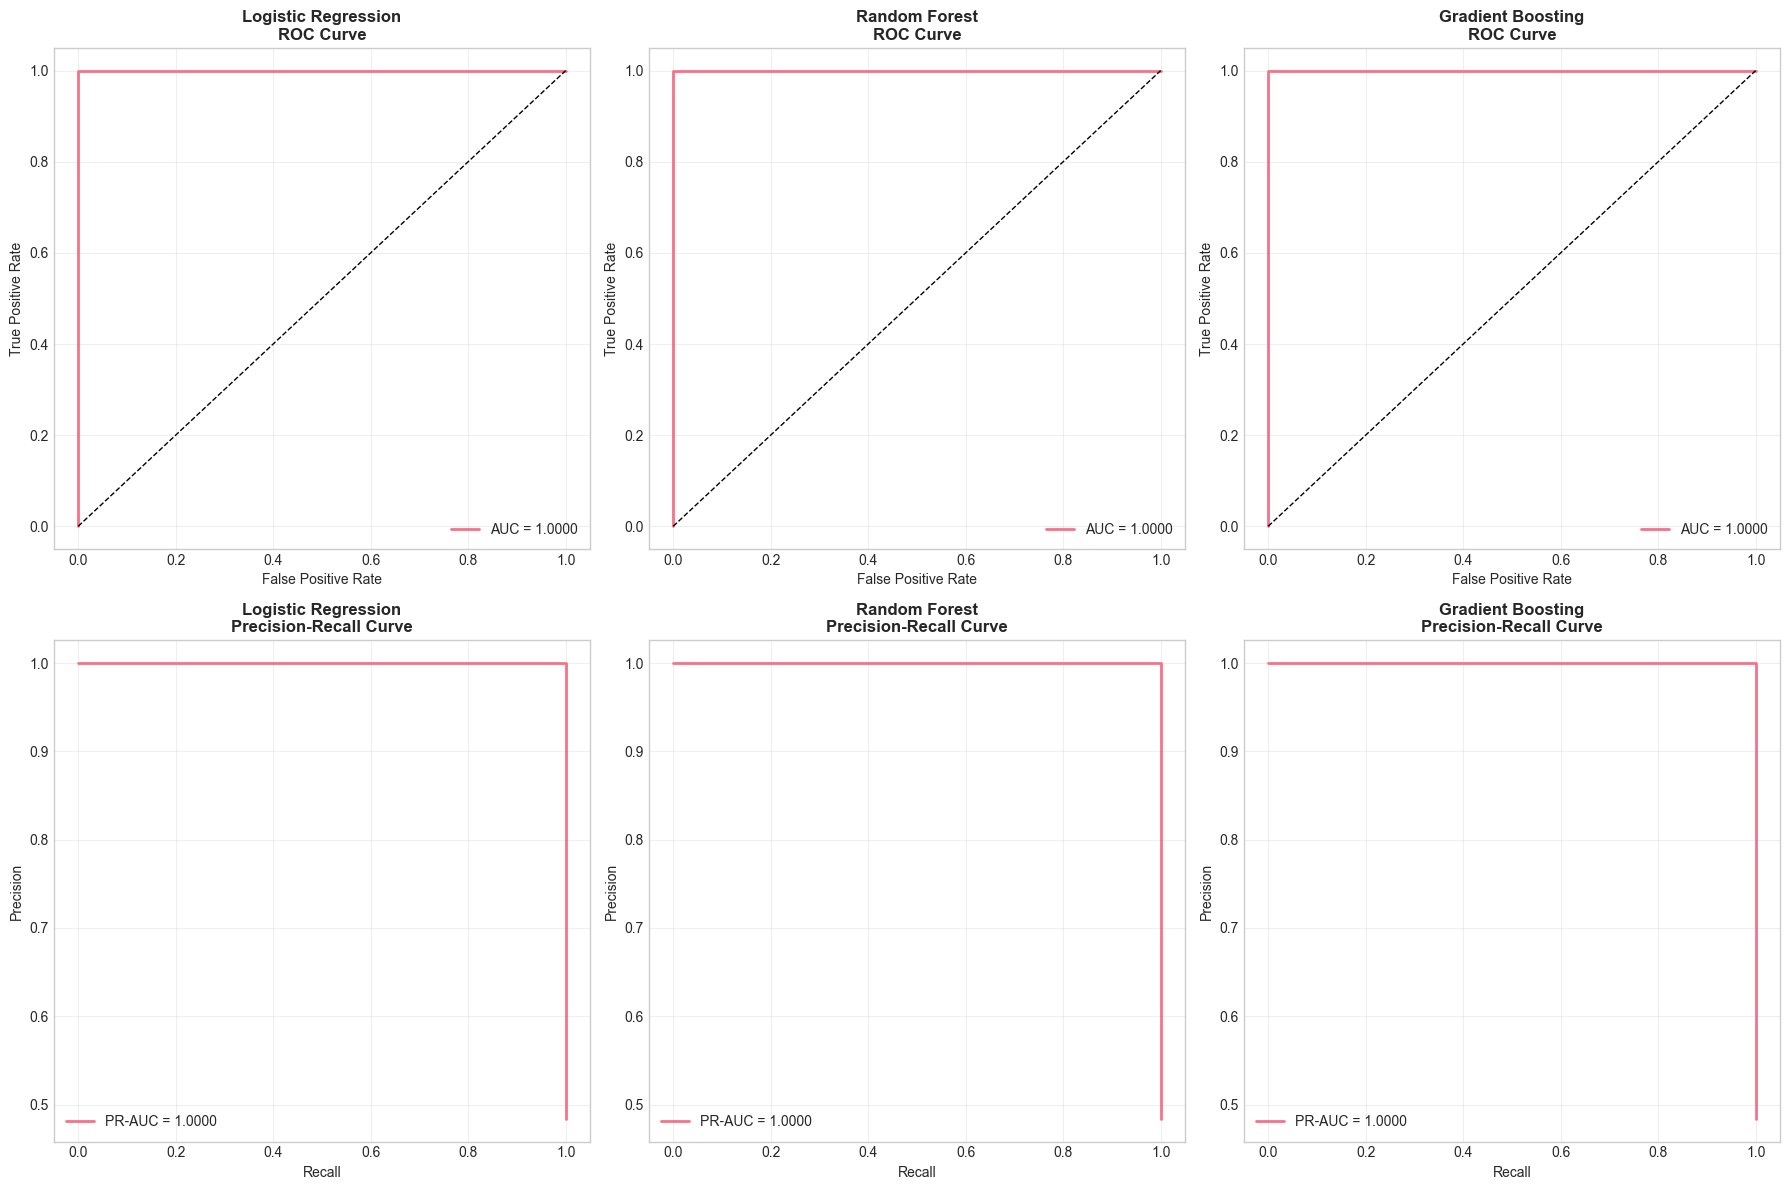

In [22]:
# Visualize model performance
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for idx, (name, result) in enumerate(results.items()):
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, result['y_proba'])
    axes[0, idx].plot(fpr, tpr, linewidth=2, label=f'AUC = {result["auc"]:.4f}')
    axes[0, idx].plot([0, 1], [0, 1], 'k--', linewidth=1)
    axes[0, idx].set_title(f'{name}\nROC Curve', fontweight='bold')
    axes[0, idx].set_xlabel('False Positive Rate')
    axes[0, idx].set_ylabel('True Positive Rate')
    axes[0, idx].legend()
    axes[0, idx].grid(alpha=0.3)
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, result['y_proba'])
    pr_auc = auc(recall, precision)
    axes[1, idx].plot(recall, precision, linewidth=2, label=f'PR-AUC = {pr_auc:.4f}')
    axes[1, idx].set_title(f'{name}\nPrecision-Recall Curve', fontweight='bold')
    axes[1, idx].set_xlabel('Recall')
    axes[1, idx].set_ylabel('Precision')
    axes[1, idx].legend()
    axes[1, idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

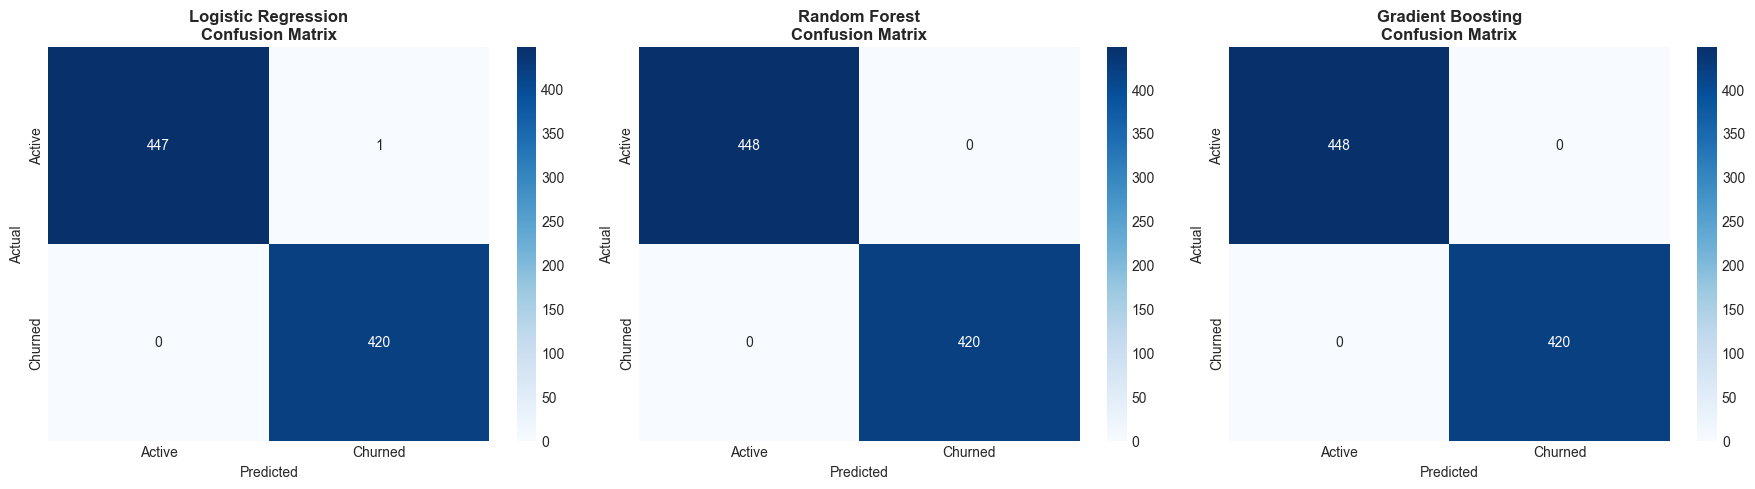

In [23]:
# Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test, result['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Active', 'Churned'], yticklabels=['Active', 'Churned'])
    axes[idx].set_title(f'{name}\nConfusion Matrix', fontweight='bold')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

plt.tight_layout()
plt.show()

📊 Top 10 Most Important Features:
                      feature  importance
0                     recency    0.336573
5                     R_score    0.169753
12              recent_amount    0.118316
11           recent_frequency    0.109279
13            frequency_trend    0.073947
14               amount_trend    0.068009
15               is_declining    0.059761
10    purchase_frequency_rate    0.039126
8                   RFM_score    0.018639
9   days_since_first_purchase    0.003103


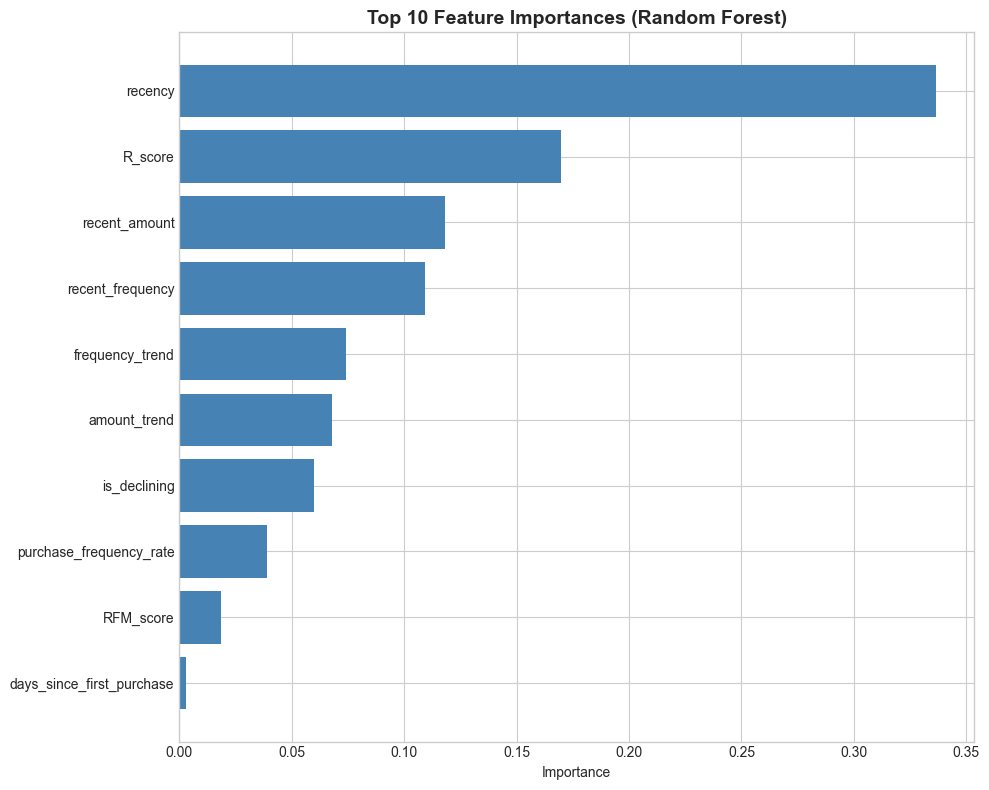

In [24]:
# Feature Importance (Random Forest)
rf_model = results['Random Forest']['model']
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("📊 Top 10 Most Important Features:")
print(feature_importance.head(10))

plt.figure(figsize=(10, 8))
plt.barh(feature_importance.head(10)['feature'], feature_importance.head(10)['importance'], color='steelblue')
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances (Random Forest)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [25]:
# Save predictions to features dataframe
best_model_name = max(results, key=lambda x: results[x]['auc'])
print(f"\n🏆 Best Model: {best_model_name} (AUC: {results[best_model_name]['auc']:.4f})")

# Predict on full dataset for later use
if best_model_name == 'Logistic Regression':
    X_scaled = scaler.transform(X)
    features['churn_probability_classification'] = results[best_model_name]['model'].predict_proba(X_scaled)[:, 1]
else:
    features['churn_probability_classification'] = results[best_model_name]['model'].predict_proba(X)[:, 1]

print("\n✅ Churn probabilities from classification model added to features")
print(f"\n📊 Churn Probability Distribution:")
print(features['churn_probability_classification'].describe())


🏆 Best Model: Logistic Regression (AUC: 1.0000)

✅ Churn probabilities from classification model added to features

📊 Churn Probability Distribution:
count    2.892000e+03
mean     4.830535e-01
std      4.923854e-01
min      1.160458e-32
25%      1.036766e-04
50%      4.138559e-02
75%      9.999027e-01
max      1.000000e+00
Name: churn_probability_classification, dtype: float64


---
# 📊 PART 3: BG-NBD Model (Probabilistic Churn)
---

### BG-NBD Model (Beta-Geometric Negative Binomial Distribution):
- **Beta-Geometric**: Models customer "death" (churn) process
- **Negative Binomial**: Models transaction frequency while alive
- **Outputs**: P(alive), Expected # transactions in next period

In [26]:
# Prepare data for BG-NBD
# Need: frequency, recency, T (customer age)
# Note: frequency in lifetimes = repeat purchases (first purchase excluded)

summary_data = summary_data_from_transaction_data(
    transactions,
    customer_id_col='customer_id',
    datetime_col='transaction_date',
    monetary_value_col='amount',
    observation_period_end=OBSERVATION_DATE
)

print("📊 BG-NBD Summary Data:")
print(summary_data.head(10))
print(f"\nShape: {summary_data.shape}")
print("\nColumn Definitions:")
print("  frequency: Number of repeat purchases (first purchase excluded)")
print("  recency: Age at last purchase (days from first to last purchase)")
print("  T: Customer age (days from first purchase to observation date)")
print("  monetary_value: Average transaction value (repeat purchases only)")

📊 BG-NBD Summary Data:
             frequency  recency      T  monetary_value
customer_id                                           
C00000            11.0    112.0  112.0       93.370000
C00001            17.0    278.0  289.0       68.373529
C00002             9.0     37.0  133.0       86.307778
C00003             3.0     45.0   88.0       19.393333
C00004            17.0     98.0  206.0      109.965882
C00005             6.0     46.0   48.0       29.576667
C00006             2.0     82.0  118.0       32.875000
C00007             4.0     50.0  142.0       88.840000
C00008            12.0    176.0  237.0       56.019167
C00009            17.0    163.0  358.0       95.345294

Shape: (2892, 4)

Column Definitions:
  frequency: Number of repeat purchases (first purchase excluded)
  recency: Age at last purchase (days from first to last purchase)
  T: Customer age (days from first purchase to observation date)
  monetary_value: Average transaction value (repeat purchases only)


In [27]:
# Fit BG-NBD Model
bgf = BetaGeoFitter(penalizer_coef=0.01)
bgf.fit(summary_data['frequency'], summary_data['recency'], summary_data['T'])

print("✅ BG-NBD Model Fitted Successfully!")
print("\n📊 Model Parameters:")
print(bgf.summary)

✅ BG-NBD Model Fitted Successfully!

📊 Model Parameters:
           coef  se(coef)  lower 95% bound  upper 95% bound
r      1.349871  0.037787         1.275810         1.423933
alpha  9.617741  0.321275         8.988042        10.247440
a      0.277815  0.010070         0.258077         0.297552
b      2.005922  0.082463         1.844294         2.167549


In [28]:
# Calculate P(alive) and expected transactions
summary_data['p_alive'] = bgf.conditional_probability_alive(
    summary_data['frequency'], 
    summary_data['recency'], 
    summary_data['T']
)

# Expected purchases in next 30, 60, 90 days
for days in [30, 60, 90]:
    summary_data[f'expected_purchases_{days}d'] = bgf.conditional_expected_number_of_purchases_up_to_time(
        days,
        summary_data['frequency'],
        summary_data['recency'],
        summary_data['T']
    )

print("📊 BG-NBD Predictions:")
print(summary_data[['frequency', 'recency', 'T', 'p_alive', 
                     'expected_purchases_30d', 'expected_purchases_60d', 'expected_purchases_90d']].head(10))

print(f"\n📊 P(alive) Statistics:")
print(summary_data['p_alive'].describe())

📊 BG-NBD Predictions:
             frequency  recency      T   p_alive  expected_purchases_30d  \
customer_id                                                                
C00000            11.0    112.0  112.0  0.977384                2.884475   
C00001            17.0    278.0  289.0  0.970194                1.764507   
C00002             9.0     37.0  133.0  0.000339                0.000718   
C00003             3.0     45.0   88.0  0.535590                0.688525   
C00004            17.0     98.0  206.0  0.000188                0.000471   
C00005             6.0     46.0   48.0  0.951103                3.420430   
C00006             2.0     82.0  118.0  0.780946                0.596411   
C00007             4.0     50.0  142.0  0.108884                0.112303   
C00008            12.0    176.0  237.0  0.513207                0.819965   
C00009            17.0    163.0  358.0  0.000061                0.000091   

             expected_purchases_60d  expected_purchases_90d  
cus

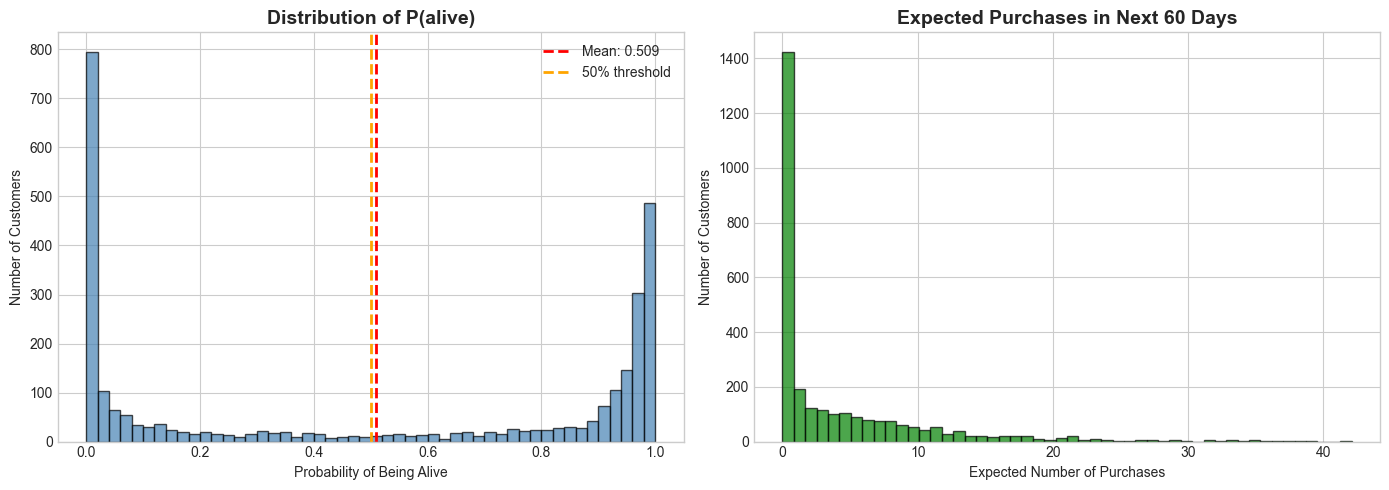


--- Frequency-Recency Matrix ---


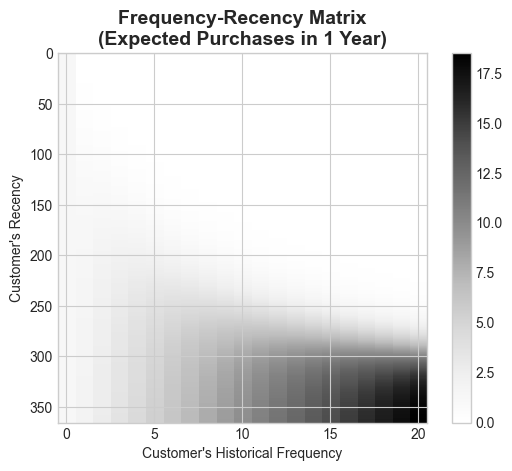


--- Probability Alive Matrix ---


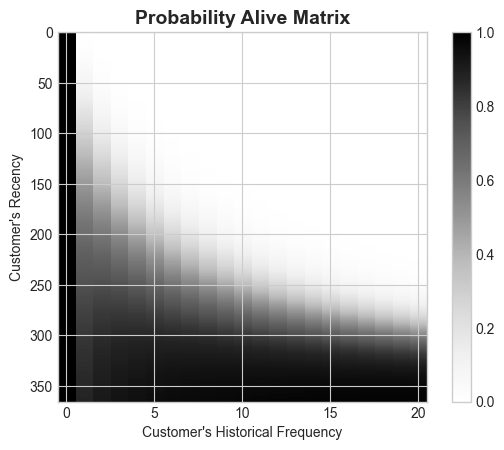

In [33]:
# Visualize BG-NBD outputs - Part 1: Histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# P(alive) distribution
axes[0].hist(summary_data['p_alive'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_title('Distribution of P(alive)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Probability of Being Alive')
axes[0].set_ylabel('Number of Customers')
axes[0].axvline(summary_data['p_alive'].mean(), color='red', linestyle='--', linewidth=2, 
                   label=f'Mean: {summary_data["p_alive"].mean():.3f}')
axes[0].axvline(0.5, color='orange', linestyle='--', linewidth=2, label='50% threshold')
axes[0].legend()

# Expected purchases distribution
axes[1].hist(summary_data['expected_purchases_60d'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].set_title('Expected Purchases in Next 60 Days', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Expected Number of Purchases')
axes[1].set_ylabel('Number of Customers')

plt.tight_layout()
plt.show()

# Frequency-Recency Matrix (separate plot - lifetimes creates its own figure)
print("\n--- Frequency-Recency Matrix ---")
plot_frequency_recency_matrix(bgf, T=365, max_frequency=20, max_recency=365)
plt.title('Frequency-Recency Matrix\n(Expected Purchases in 1 Year)', fontsize=14, fontweight='bold')
plt.show()

# Probability Alive Matrix (separate plot - lifetimes creates its own figure)
print("\n--- Probability Alive Matrix ---")
plot_probability_alive_matrix(bgf, max_frequency=20, max_recency=365)
plt.title('Probability Alive Matrix', fontsize=14, fontweight='bold')
plt.show()

In [34]:
# Merge BG-NBD results with features
features = features.merge(summary_data[['p_alive', 'expected_purchases_30d', 'expected_purchases_60d', 'expected_purchases_90d']], 
                         left_on='customer_id', right_index=True, how='left', suffixes=('', '_bgnbd'))

# Calculate churn probability from BG-NBD (1 - p_alive)
features['churn_probability_bgnbd'] = 1 - features['p_alive']

print("✅ BG-NBD predictions merged with features")

✅ BG-NBD predictions merged with features


## Comparison: Classification Churn vs BG-NBD P(alive)


📊 Correlation between Classification and BG-NBD churn probabilities: 0.7915


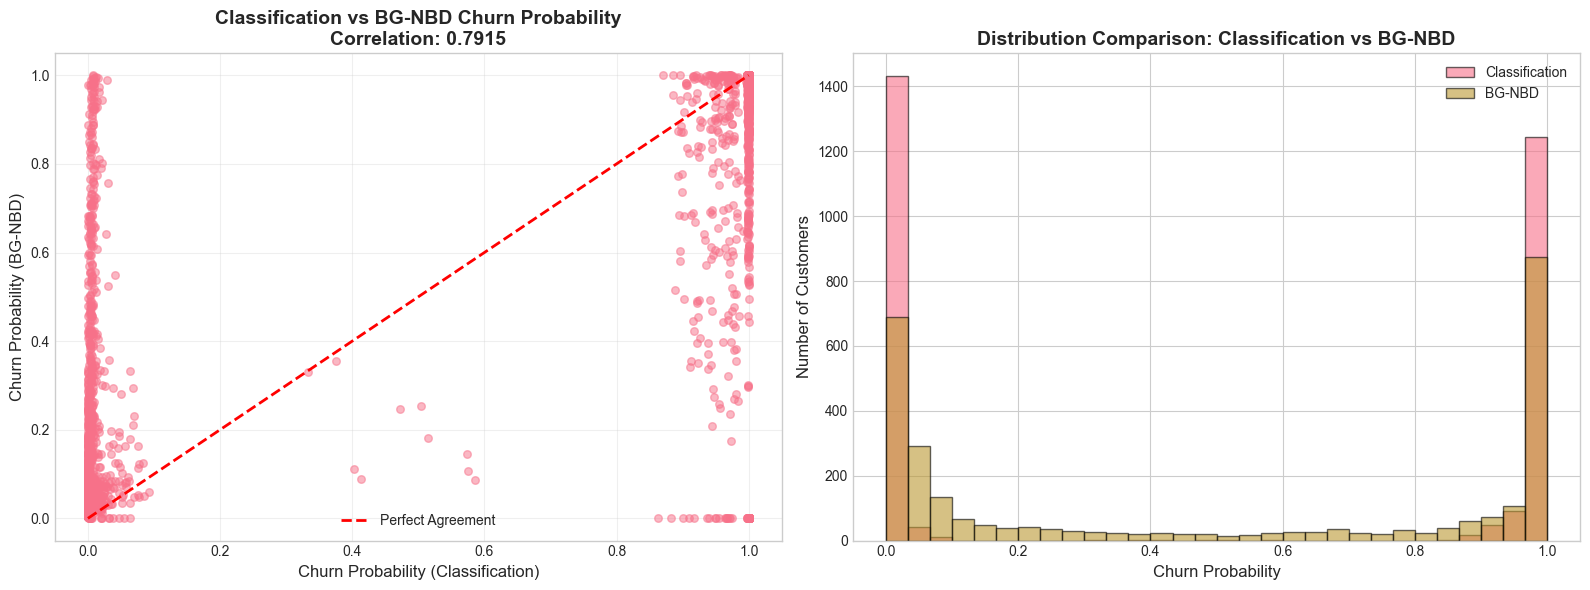

In [35]:
# Correlation between methods
correlation = features['churn_probability_classification'].corr(features['churn_probability_bgnbd'])
print(f"\n📊 Correlation between Classification and BG-NBD churn probabilities: {correlation:.4f}")

# Scatter plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter: Classification vs BG-NBD
axes[0].scatter(features['churn_probability_classification'], 
                features['churn_probability_bgnbd'], alpha=0.5, s=30)
axes[0].plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect Agreement')
axes[0].set_xlabel('Churn Probability (Classification)', fontsize=12)
axes[0].set_ylabel('Churn Probability (BG-NBD)', fontsize=12)
axes[0].set_title(f'Classification vs BG-NBD Churn Probability\nCorrelation: {correlation:.4f}', 
                  fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Distributions comparison
axes[1].hist(features['churn_probability_classification'], bins=30, alpha=0.6, label='Classification', edgecolor='black')
axes[1].hist(features['churn_probability_bgnbd'], bins=30, alpha=0.6, label='BG-NBD', edgecolor='black')
axes[1].set_xlabel('Churn Probability', fontsize=12)
axes[1].set_ylabel('Number of Customers', fontsize=12)
axes[1].set_title('Distribution Comparison: Classification vs BG-NBD', fontsize=14, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

In [36]:
# Agreement analysis
threshold = 0.5

features['high_risk_classification'] = (features['churn_probability_classification'] > threshold).astype(int)
features['high_risk_bgnbd'] = (features['churn_probability_bgnbd'] > threshold).astype(int)

agreement_matrix = pd.crosstab(
    features['high_risk_classification'], 
    features['high_risk_bgnbd'],
    rownames=['Classification'],
    colnames=['BG-NBD']
)

print("\n📊 High-Risk Customer Agreement Matrix (threshold = 0.5):")
print(agreement_matrix)

agreement_rate = (agreement_matrix.values[0, 0] + agreement_matrix.values[1, 1]) / features.shape[0]
print(f"\nAgreement Rate: {agreement_rate*100:.2f}%")


📊 High-Risk Customer Agreement Matrix (threshold = 0.5):
BG-NBD             0     1
Classification            
0               1331   158
1                172  1231

Agreement Rate: 88.59%


---
# 📊 PART 4: Survival Analysis
---

### Survival Analysis Concepts:
- **Duration**: Time from first purchase to last purchase (or censoring)
- **Event**: Churn occurred (1) or customer still active (0 = censored)
- **Survival Function**: S(t) = Probability of surviving beyond time t
- **Hazard Function**: Risk of churn at time t given survival up to t

In [37]:
# Prepare survival data
def prepare_survival_data(features_df, churn_col='churn_60d'):
    """
    Prepare data for survival analysis
    Duration: days from first to last purchase
    Event: 1 if churned, 0 if still active (censored)
    """
    survival_df = features_df.copy()
    
    # Duration: customer lifetime (days from first to last purchase)
    survival_df['duration'] = (survival_df['last_purchase'] - survival_df['first_purchase']).dt.days + 1
    survival_df['duration'] = survival_df['duration'].clip(lower=1)  # Minimum 1 day
    
    # Event: 1 if churned, 0 if still active (censored)
    survival_df['event'] = survival_df[churn_col]
    
    return survival_df

survival_data = prepare_survival_data(features)

print("📊 Survival Data:")
print(survival_data[['customer_id', 'duration', 'event', 'first_purchase', 'last_purchase']].head(10))
print(f"\nTotal Customers: {survival_data.shape[0]}")
print(f"Events (Churned): {survival_data['event'].sum()}")
print(f"Censored (Active): {(1 - survival_data['event']).sum()}")
print(f"\nDuration Statistics:")
print(survival_data['duration'].describe())

📊 Survival Data:
  customer_id  duration  event first_purchase last_purchase
0      C00000       113      0     2025-09-10    2025-12-31
1      C00001       279      0     2025-03-17    2025-12-20
2      C00002        38      1     2025-08-20    2025-09-26
3      C00003        46      0     2025-10-04    2025-11-18
4      C00004        99      1     2025-06-08    2025-09-14
5      C00005        47      0     2025-11-13    2025-12-29
6      C00006        83      0     2025-09-04    2025-11-25
7      C00007        51      1     2025-08-11    2025-09-30
8      C00008       177      1     2025-05-08    2025-10-31
9      C00009       164      1     2025-01-07    2025-06-19

Total Customers: 2892
Events (Churned): 1398
Censored (Active): 1494

Duration Statistics:
count    2892.000000
mean       96.550830
std        72.430698
min         1.000000
25%        38.000000
50%        81.000000
75%       141.250000
max       355.000000
Name: duration, dtype: float64


✅ Kaplan-Meier Model Fitted

📊 Survival Statistics:
Median Survival Time: 141.00 days


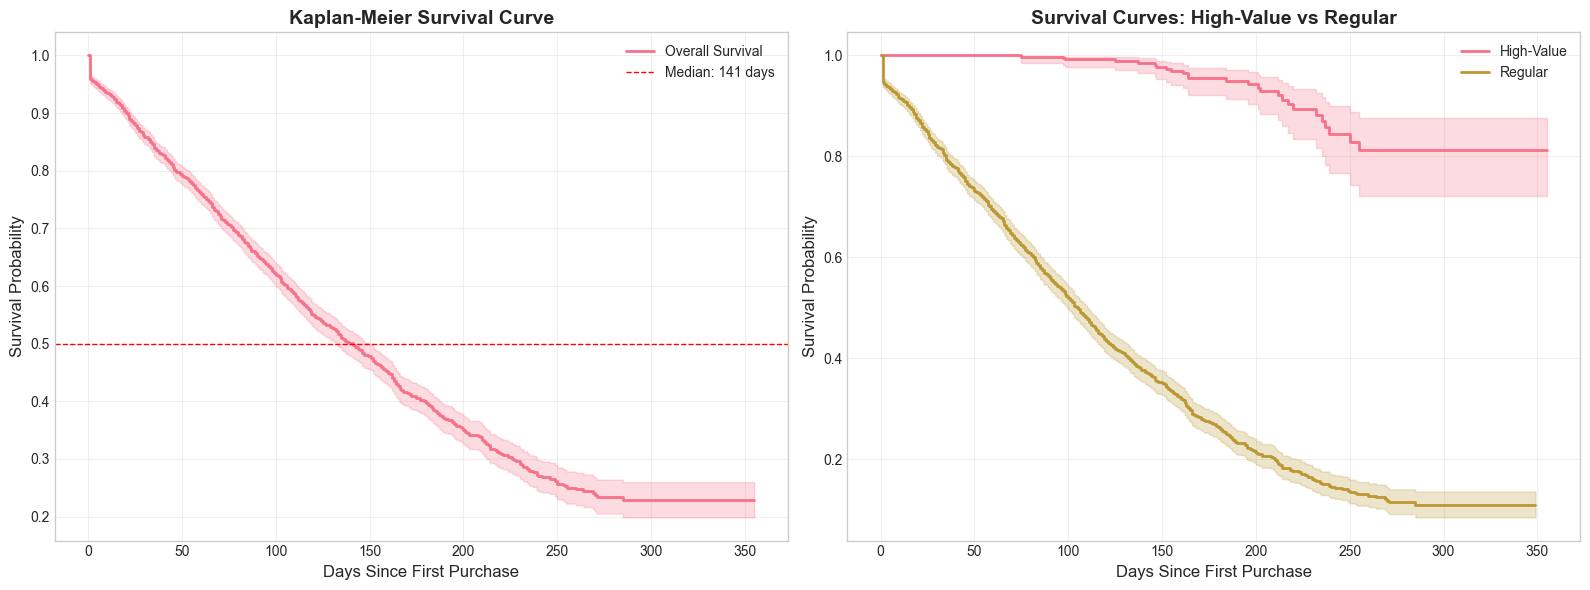

In [38]:
# Kaplan-Meier Survival Curve
kmf = KaplanMeierFitter()
kmf.fit(survival_data['duration'], survival_data['event'], label='Overall Survival')

print("✅ Kaplan-Meier Model Fitted")
print("\n📊 Survival Statistics:")
print(f"Median Survival Time: {kmf.median_survival_time_:.2f} days")

# Plot Kaplan-Meier curve
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Overall survival curve
kmf.plot_survival_function(ax=axes[0], linewidth=2)
axes[0].set_title('Kaplan-Meier Survival Curve', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Days Since First Purchase', fontsize=12)
axes[0].set_ylabel('Survival Probability', fontsize=12)
axes[0].axhline(0.5, color='red', linestyle='--', linewidth=1, label=f'Median: {kmf.median_survival_time_:.0f} days')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Survival by High-Value segment
for segment in ['High-Value', 'Regular']:
    if segment == 'High-Value':
        mask = survival_data['is_high_value'] == 1
    else:
        mask = survival_data['is_high_value'] == 0
    
    kmf_seg = KaplanMeierFitter()
    kmf_seg.fit(survival_data[mask]['duration'], survival_data[mask]['event'], label=segment)
    kmf_seg.plot_survival_function(ax=axes[1], linewidth=2)

axes[1].set_title('Survival Curves: High-Value vs Regular', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Days Since First Purchase', fontsize=12)
axes[1].set_ylabel('Survival Probability', fontsize=12)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [39]:
# Cox Proportional Hazards Model
cox_features = [
    'recency', 'frequency', 'monetary', 'RFM_score',
    'purchase_frequency_rate', 'recent_frequency', 'frequency_trend',
    'is_declining', 'cv'
]

cox_data = survival_data[cox_features + ['duration', 'event']].copy()
cox_data = cox_data.fillna(0)

# Fit Cox PH model
cph = CoxPHFitter(penalizer=0.01)
cph.fit(cox_data, duration_col='duration', event_col='event')

print("✅ Cox Proportional Hazards Model Fitted")
print("\n📊 Model Summary:")
print(cph.summary)

✅ Cox Proportional Hazards Model Fitted

📊 Model Summary:
                             coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                                
recency                  0.007985   1.008017  0.000485        0.007034   
frequency               -0.043665   0.957275  0.004553       -0.052588   
monetary                 0.005569   1.005585  0.000771        0.004058   
RFM_score               -0.215164   0.806409  0.021946       -0.258179   
purchase_frequency_rate  3.232001  25.330286  0.810799        1.642864   
recent_frequency        -0.175418   0.839106  0.023262       -0.221011   
frequency_trend         -0.100262   0.904601  0.031575       -0.162147   
is_declining            -2.889557   0.055601  0.221038       -3.322783   
cv                      -1.287072   0.276078  0.134462       -1.550612   

                         coef upper 95%  exp(coef) lower 95%  \
covariate                                                      

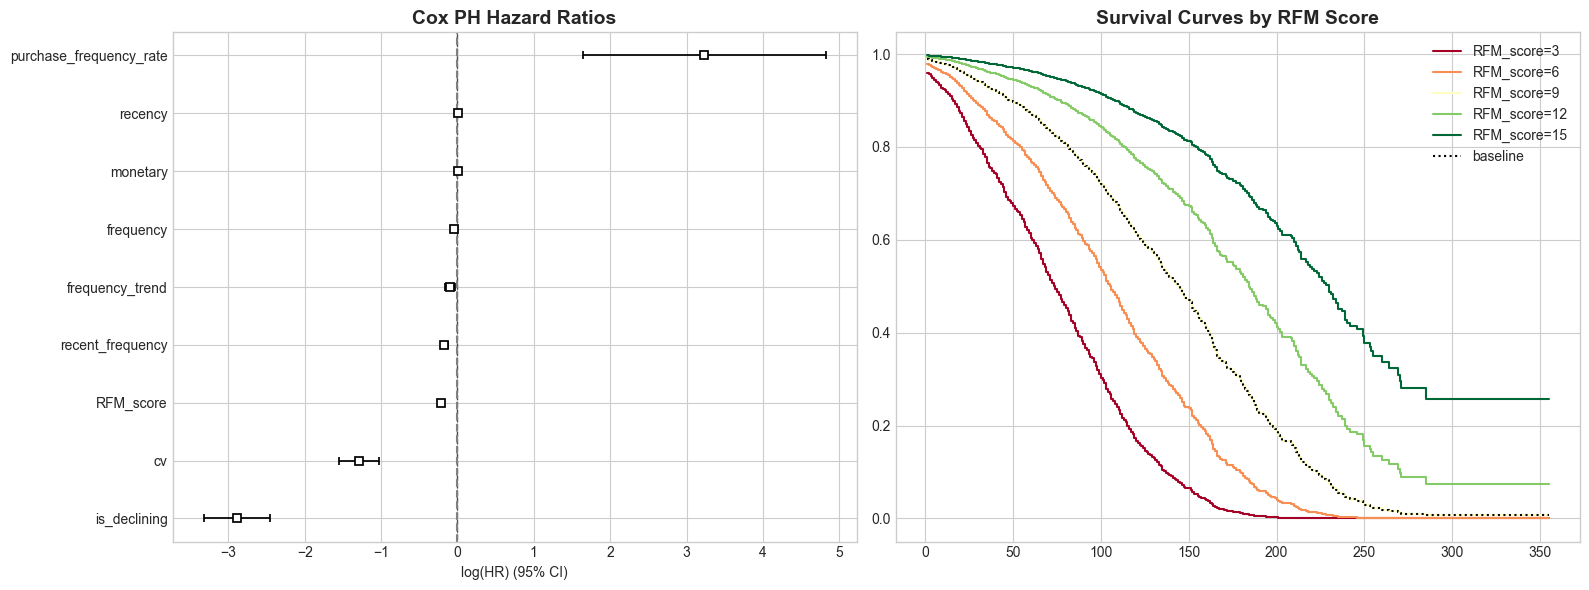

In [40]:
# Plot Cox model results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Hazard ratios
cph.plot(ax=axes[0])
axes[0].set_title('Cox PH Hazard Ratios', fontsize=14, fontweight='bold')
axes[0].axvline(0, color='gray', linestyle='--')

# Partial effects of RFM score
cph.plot_partial_effects_on_outcome(covariates='RFM_score', values=[3, 6, 9, 12, 15], 
                                    cmap='RdYlGn', ax=axes[1])
axes[1].set_title('Survival Curves by RFM Score', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [41]:
# Predict survival probabilities
survival_data['median_survival_time'] = cph.predict_median(cox_data[cox_features])
survival_data['expected_remaining_lifetime'] = survival_data['median_survival_time'] - survival_data['duration']
survival_data['expected_remaining_lifetime'] = survival_data['expected_remaining_lifetime'].clip(lower=0)

# Survival probability at specific time points
for days in [30, 60, 90, 180]:
    survival_probs = cph.predict_survival_function(cox_data[cox_features], times=[days])
    survival_data[f'survival_prob_{days}d'] = survival_probs.values.flatten()
    survival_data[f'churn_risk_{days}d'] = 1 - survival_data[f'survival_prob_{days}d']

print("✅ Survival predictions added to data")
print("\n📊 Survival Predictions Sample:")
print(survival_data[['customer_id', 'median_survival_time', 'expected_remaining_lifetime',
                     'survival_prob_60d', 'churn_risk_60d']].head(10))

✅ Survival predictions added to data

📊 Survival Predictions Sample:
  customer_id  median_survival_time  expected_remaining_lifetime  \
0      C00000                   inf                          inf   
1      C00001                   inf                          inf   
2      C00002                 106.0                         68.0   
3      C00003                   inf                          inf   
4      C00004                 151.0                         52.0   
5      C00005                   inf                          inf   
6      C00006                 264.0                        181.0   
7      C00007                  91.0                         40.0   
8      C00008                 132.0                          0.0   
9      C00009                  97.0                          0.0   

   survival_prob_60d  churn_risk_60d  
0           0.998747        0.001253  
1           0.981281        0.018719  
2           0.772114        0.227886  
3           0.984189      

---
# 📊 PART 5: CLV Modeling
---

### Two Approaches:
1. **BG-NBD + Gamma-Gamma**: Traditional probabilistic approach
2. **Survival Analysis + Gamma-Gamma**: Using survival probabilities

In [42]:
# Gamma-Gamma Model (for monetary value prediction)
# Filter customers with >1 purchase for Gamma-Gamma
returning_customers_summary = summary_data[summary_data['frequency'] > 0].copy()

print(f"📊 Customers for Gamma-Gamma Model: {returning_customers_summary.shape[0]}")
print(f"   (Customers with at least 2 purchases)")

# Fit Gamma-Gamma model
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(returning_customers_summary['frequency'], returning_customers_summary['monetary_value'])

print("\n✅ Gamma-Gamma Model Fitted")
print("\n📊 Model Parameters:")
print(ggf.summary)

📊 Customers for Gamma-Gamma Model: 2755
   (Customers with at least 2 purchases)

✅ Gamma-Gamma Model Fitted

📊 Model Parameters:
       coef  se(coef)  lower 95% bound  upper 95% bound
p  3.864165  0.091021         3.685764         4.042566
q  0.687321  0.015774         0.656404         0.718237
v  3.830656  0.092474         3.649406         4.011906


In [43]:
# Calculate expected average transaction value
returning_customers_summary['expected_avg_profit'] = ggf.conditional_expected_average_profit(
    returning_customers_summary['frequency'],
    returning_customers_summary['monetary_value']
)

print("📊 Expected Transaction Values:")
print(returning_customers_summary[['frequency', 'monetary_value', 'expected_avg_profit']].describe())

📊 Expected Transaction Values:
         frequency  monetary_value  expected_avg_profit
count  2755.000000     2755.000000          2755.000000
mean     13.916515       64.165748            66.004991
std      13.574812       44.915232            46.025157
min       1.000000        0.690000             1.681683
25%       4.000000       32.766108            34.123214
50%      10.000000       54.921786            56.449687
75%      19.000000       83.850667            86.050737
max     113.000000      476.210000           522.304339


In [44]:
# Calculate CLV using BG-NBD + Gamma-Gamma
TIME_HORIZON = 365  # 1 year
DISCOUNT_RATE = 0.01  # Monthly discount rate (~12% annually)

# CLV calculation for returning customers
returning_customers_summary['clv_bgnbd_12m'] = ggf.customer_lifetime_value(
    bgf,
    returning_customers_summary['frequency'],
    returning_customers_summary['recency'],
    returning_customers_summary['T'],
    returning_customers_summary['monetary_value'],
    time=12,  # 12 months
    discount_rate=DISCOUNT_RATE
)

print("✅ CLV (BG-NBD + Gamma-Gamma) calculated")
print("\n📊 CLV Statistics:")
print(returning_customers_summary[['p_alive', 'expected_avg_profit', 'clv_bgnbd_12m']].describe())

✅ CLV (BG-NBD + Gamma-Gamma) calculated

📊 CLV Statistics:
            p_alive  expected_avg_profit  clv_bgnbd_12m
count  2.755000e+03          2755.000000   2.755000e+03
mean   4.848247e-01            66.004991   1.475574e+03
std    4.303885e-01            46.025157   3.271416e+03
min    3.085812e-18             1.681683   2.622948e-15
25%    9.763915e-03            34.123214   3.447057e+00
50%    4.726812e-01            56.449687   2.556572e+02
75%    9.540221e-01            86.050737   1.648772e+03
max    9.975691e-01           522.304339   5.239073e+04


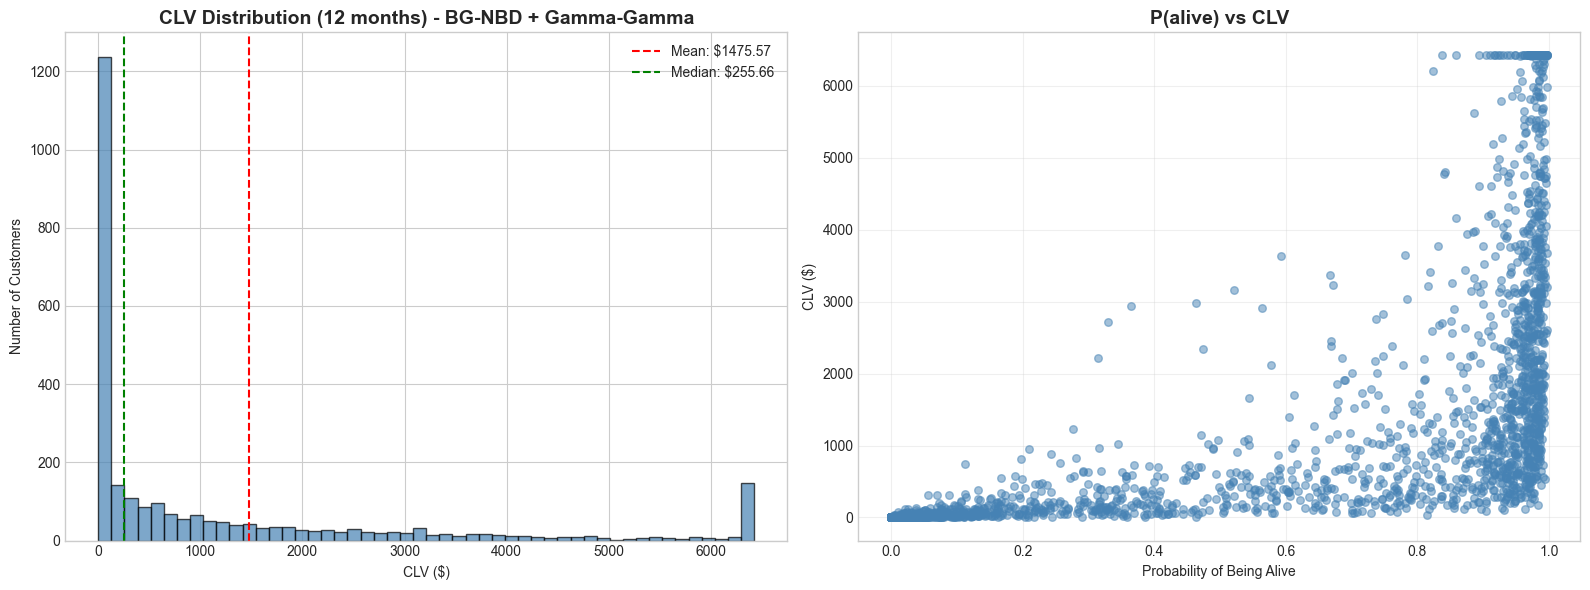

In [45]:
# Visualize CLV distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# CLV distribution (capped at 95th percentile for visualization)
clv_cap = returning_customers_summary['clv_bgnbd_12m'].quantile(0.95)
axes[0].hist(returning_customers_summary['clv_bgnbd_12m'].clip(upper=clv_cap), 
             bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_title('CLV Distribution (12 months) - BG-NBD + Gamma-Gamma', fontsize=14, fontweight='bold')
axes[0].set_xlabel('CLV ($)')
axes[0].set_ylabel('Number of Customers')
axes[0].axvline(returning_customers_summary['clv_bgnbd_12m'].mean(), color='red', linestyle='--', 
                label=f'Mean: ${returning_customers_summary["clv_bgnbd_12m"].mean():.2f}')
axes[0].axvline(returning_customers_summary['clv_bgnbd_12m'].median(), color='green', linestyle='--', 
                label=f'Median: ${returning_customers_summary["clv_bgnbd_12m"].median():.2f}')
axes[0].legend()

# P(alive) vs CLV
axes[1].scatter(returning_customers_summary['p_alive'], 
                returning_customers_summary['clv_bgnbd_12m'].clip(upper=clv_cap),
                alpha=0.5, s=30, c='steelblue')
axes[1].set_title('P(alive) vs CLV', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Probability of Being Alive')
axes[1].set_ylabel('CLV ($)')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [46]:
# Merge CLV data to main features
features = features.merge(
    returning_customers_summary[['clv_bgnbd_12m', 'expected_avg_profit']],
    left_on='customer_id',
    right_index=True,
    how='left'
)

# Fill NaN for customers with only 1 purchase
features['clv_bgnbd_12m'] = features['clv_bgnbd_12m'].fillna(features['monetary'])
features['expected_avg_profit'] = features['expected_avg_profit'].fillna(features['monetary'])

print("✅ CLV merged to features")

✅ CLV merged to features


In [47]:
# CLV using Survival approach
# Merge survival predictions with features
features = features.merge(
    survival_data[['customer_id', 'churn_risk_60d', 'survival_prob_60d', 'expected_remaining_lifetime']],
    on='customer_id',
    how='left'
)

# Calculate survival-based CLV
# CLV = Expected transactions * Expected value * Survival probability
features['clv_survival_12m'] = (
    features['expected_purchases_60d'] * 6 *  # Annualize 60-day predictions
    features['expected_avg_profit'] * 
    features['survival_prob_60d']
)

# Handle NaN values
features['clv_survival_12m'] = features['clv_survival_12m'].fillna(0)

print("✅ Survival-based CLV calculated")
print("\n📊 CLV Comparison:")
print(features[['clv_bgnbd_12m', 'clv_survival_12m']].describe())

✅ Survival-based CLV calculated

📊 CLV Comparison:
       clv_bgnbd_12m  clv_survival_12m
count   2.892000e+03      2.892000e+03
mean    1.408428e+03      1.804573e+03
std     3.207155e+03      4.297684e+03
min     2.622948e-15      2.454295e-15
25%     4.715406e+00      1.651183e+00
50%     1.897287e+02      2.172639e+02
75%     1.516499e+03      1.883804e+03
max     5.239073e+04      7.305944e+04


---
# 📊 PART 6: Final Business Question - Retention Strategy Comparison
---

### 🎯 Scenario: Ngân sách retention chỉ đủ giữ 20% customer base

### 3 Strategies to Compare:
1. **High Churn Probability (Classification)**: Target top 20% highest churn risk
2. **Low P(alive) (BG-NBD)**: Target bottom 20% P(alive)
3. **High CLV × High Churn Risk (Survival-based)**: Target high-value customers at risk

In [48]:
# Prepare final data for strategy comparison
final_data = features.copy()

# Ensure all necessary columns are present
print("📊 Final Data Columns:")
print(final_data.columns.tolist())
print(f"\nShape: {final_data.shape}")

📊 Final Data Columns:
['customer_id', 'recency', 'frequency', 'monetary', 'total_spent', 'first_purchase', 'last_purchase', 'customer_age_days', 'R_score', 'F_score', 'M_score', 'RFM_score', 'segment', 'is_high_value', 'is_at_risk', 'churn', 'churn_30d', 'churn_45d', 'churn_60d', 'churn_90d', 'days_since_first_purchase', 'days_since_last_purchase', 'purchase_frequency_rate', 'recent_frequency', 'recent_amount', 'previous_frequency', 'previous_amount', 'frequency_trend', 'amount_trend', 'is_declining', 'cv', 'churn_probability_classification', 'p_alive', 'expected_purchases_30d', 'expected_purchases_60d', 'expected_purchases_90d', 'churn_probability_bgnbd', 'high_risk_classification', 'high_risk_bgnbd', 'clv_bgnbd_12m', 'expected_avg_profit', 'churn_risk_60d', 'survival_prob_60d', 'expected_remaining_lifetime', 'clv_survival_12m']

Shape: (2892, 45)


In [49]:
# Define retention strategies
TOP_PERCENT = 0.20  # Top 20% to target
n_target = int(len(final_data) * TOP_PERCENT)

print(f"🎯 Target: Top {TOP_PERCENT*100:.0f}% customers = {n_target} customers")
print("\n" + "="*80)

# Strategy 1: High Churn Probability (Classification)
strategy1_targets = final_data.nlargest(n_target, 'churn_probability_classification')['customer_id'].tolist()
print(f"\n📌 Strategy 1: High Churn Probability (Classification)")
print(f"   Threshold: {final_data['churn_probability_classification'].quantile(1-TOP_PERCENT):.4f}")
print(f"   Customers selected: {len(strategy1_targets)}")

# Strategy 2: Low P(alive) (BG-NBD)
strategy2_targets = final_data.nsmallest(n_target, 'p_alive')['customer_id'].tolist()
print(f"\n📌 Strategy 2: Low P(alive) (BG-NBD)")
print(f"   Threshold: {final_data['p_alive'].quantile(TOP_PERCENT):.4f}")
print(f"   Customers selected: {len(strategy2_targets)}")

# Strategy 3: High CLV × High Churn Risk
# Create composite score: CLV × Churn Risk
final_data['clv_risk_score'] = final_data['clv_bgnbd_12m'] * final_data['churn_risk_60d']
strategy3_targets = final_data.nlargest(n_target, 'clv_risk_score')['customer_id'].tolist()
print(f"\n📌 Strategy 3: High CLV × High Churn Risk (Survival-based)")
print(f"   Composite score = CLV × Churn Risk")
print(f"   Customers selected: {len(strategy3_targets)}")

🎯 Target: Top 20% customers = 578 customers


📌 Strategy 1: High Churn Probability (Classification)
   Threshold: 1.0000
   Customers selected: 578

📌 Strategy 2: Low P(alive) (BG-NBD)
   Threshold: 0.0039
   Customers selected: 578

📌 Strategy 3: High CLV × High Churn Risk (Survival-based)
   Composite score = CLV × Churn Risk
   Customers selected: 578


In [50]:
# Evaluate each strategy
def evaluate_strategy(data, target_ids, strategy_name):
    """
    Evaluate retention strategy performance
    """
    targeted = data[data['customer_id'].isin(target_ids)]
    
    metrics = {
        'strategy': strategy_name,
        'num_customers': len(targeted),
        'actual_churn_rate': targeted['churn_60d'].mean() * 100,
        'avg_churn_prob_class': targeted['churn_probability_classification'].mean(),
        'avg_p_alive': targeted['p_alive'].mean(),
        'avg_clv': targeted['clv_bgnbd_12m'].mean(),
        'total_clv_at_risk': targeted['clv_bgnbd_12m'].sum(),
        'avg_rfm_score': targeted['RFM_score'].mean(),
        'high_value_pct': targeted['is_high_value'].mean() * 100,
        'avg_total_spent': targeted['total_spent'].mean(),
        'avg_frequency': targeted['frequency'].mean()
    }
    
    return metrics

strategy_results = []
strategy_results.append(evaluate_strategy(final_data, strategy1_targets, 'Strategy 1: High Churn Prob'))
strategy_results.append(evaluate_strategy(final_data, strategy2_targets, 'Strategy 2: Low P(alive)'))
strategy_results.append(evaluate_strategy(final_data, strategy3_targets, 'Strategy 3: CLV × Risk'))

results_df = pd.DataFrame(strategy_results)
print("\n📊 STRATEGY COMPARISON RESULTS:")
print("="*100)
print(results_df.to_string(index=False))


📊 STRATEGY COMPARISON RESULTS:
                   strategy  num_customers  actual_churn_rate  avg_churn_prob_class  avg_p_alive     avg_clv  total_clv_at_risk  avg_rfm_score  high_value_pct  avg_total_spent  avg_frequency
Strategy 1: High Churn Prob            578         100.000000              0.999999     0.117426    9.817590        5674.567047       6.145329        0.000000       486.329221       8.022491
   Strategy 2: Low P(alive)            578          99.480969              0.991588     0.000565    0.490971         283.781336       7.745675        2.595156       929.754810      16.842561
     Strategy 3: CLV × Risk            578          41.349481              0.419165     0.769733 1549.012977      895329.500825       9.389273       21.972318       667.854810       8.740484


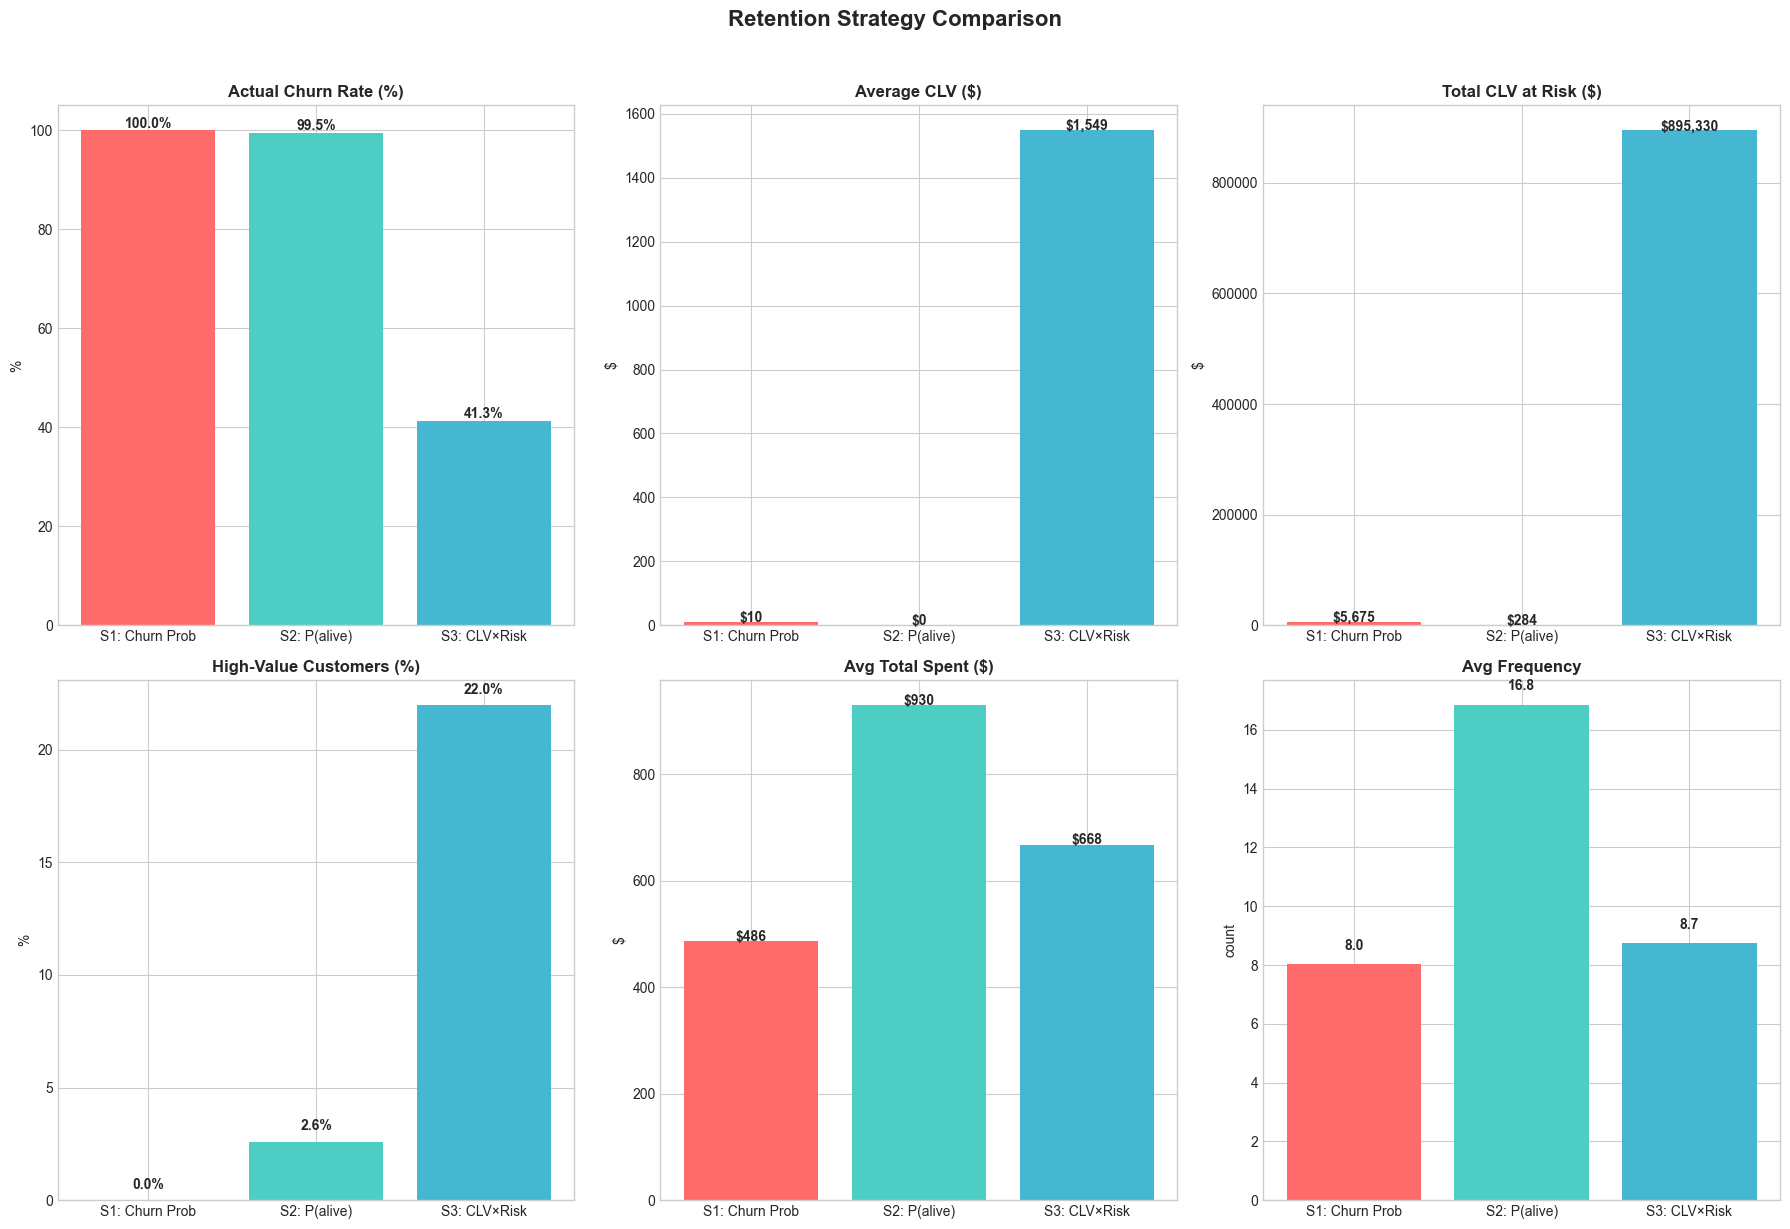

In [51]:
# Visualize strategy comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

metrics_to_plot = [
    ('actual_churn_rate', 'Actual Churn Rate (%)', '%'),
    ('avg_clv', 'Average CLV ($)', '$'),
    ('total_clv_at_risk', 'Total CLV at Risk ($)', '$'),
    ('high_value_pct', 'High-Value Customers (%)', '%'),
    ('avg_total_spent', 'Avg Total Spent ($)', '$'),
    ('avg_frequency', 'Avg Frequency', 'count')
]

colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']
strategy_labels = ['S1: Churn Prob', 'S2: P(alive)', 'S3: CLV×Risk']

for idx, (metric, title, unit) in enumerate(metrics_to_plot):
    row, col = idx // 3, idx % 3
    values = results_df[metric].values
    
    bars = axes[row, col].bar(strategy_labels, values, color=colors)
    axes[row, col].set_title(title, fontsize=12, fontweight='bold')
    axes[row, col].set_ylabel(unit)
    
    # Add value labels
    for bar, val in zip(bars, values):
        if unit == '$':
            label = f'${val:,.0f}'
        elif unit == '%':
            label = f'{val:.1f}%'
        else:
            label = f'{val:.1f}'
        axes[row, col].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                           label, ha='center', fontsize=10, fontweight='bold')

plt.suptitle('Retention Strategy Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [52]:
# Overlap analysis
set1 = set(strategy1_targets)
set2 = set(strategy2_targets)
set3 = set(strategy3_targets)

print("\n📊 Strategy Overlap Analysis:")
print("="*60)
print(f"Strategy 1 ∩ Strategy 2: {len(set1 & set2)} customers ({len(set1 & set2)/n_target*100:.1f}%)")
print(f"Strategy 1 ∩ Strategy 3: {len(set1 & set3)} customers ({len(set1 & set3)/n_target*100:.1f}%)")
print(f"Strategy 2 ∩ Strategy 3: {len(set2 & set3)} customers ({len(set2 & set3)/n_target*100:.1f}%)")
print(f"All 3 strategies: {len(set1 & set2 & set3)} customers ({len(set1 & set2 & set3)/n_target*100:.1f}%)")

# Venn diagram (if matplotlib_venn is available)
try:
    from matplotlib_venn import venn3
    
    plt.figure(figsize=(10, 8))
    venn3([set1, set2, set3], 
          set_labels=('Strategy 1\n(High Churn Prob)', 'Strategy 2\n(Low P(alive))', 'Strategy 3\n(CLV×Risk)'))
    plt.title('Strategy Target Overlap', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
except ImportError:
    print("\n(matplotlib_venn not available for Venn diagram)")


📊 Strategy Overlap Analysis:
Strategy 1 ∩ Strategy 2: 332 customers (57.4%)
Strategy 1 ∩ Strategy 3: 55 customers (9.5%)
Strategy 2 ∩ Strategy 3: 0 customers (0.0%)
All 3 strategies: 0 customers (0.0%)

(matplotlib_venn not available for Venn diagram)


In [53]:
# ROI Analysis
# Assumptions:
CAMPAIGN_COST_PER_CUSTOMER = 50  # USD
RETENTION_SUCCESS_RATE = 0.30  # 30% of targeted churners can be saved

print("\n💰 ROI ANALYSIS")
print("="*80)
print(f"Assumptions:")
print(f"  • Campaign cost per customer: ${CAMPAIGN_COST_PER_CUSTOMER}")
print(f"  • Expected retention success rate: {RETENTION_SUCCESS_RATE*100:.0f}%")
print("\n")

roi_results = []
for _, row in results_df.iterrows():
    total_cost = row['num_customers'] * CAMPAIGN_COST_PER_CUSTOMER
    expected_retained = row['num_customers'] * (row['actual_churn_rate']/100) * RETENTION_SUCCESS_RATE
    expected_clv_saved = expected_retained * row['avg_clv']
    net_value = expected_clv_saved - total_cost
    roi = (net_value / total_cost) * 100 if total_cost > 0 else 0
    
    roi_results.append({
        'strategy': row['strategy'],
        'total_cost': total_cost,
        'expected_retained': expected_retained,
        'expected_clv_saved': expected_clv_saved,
        'net_value': net_value,
        'roi_pct': roi
    })

roi_df = pd.DataFrame(roi_results)
print(roi_df.to_string(index=False))


💰 ROI ANALYSIS
Assumptions:
  • Campaign cost per customer: $50
  • Expected retention success rate: 30%


                   strategy  total_cost  expected_retained  expected_clv_saved     net_value    roi_pct
Strategy 1: High Churn Prob       28900              173.4         1702.370114 -27197.629886 -94.109446
   Strategy 2: Low P(alive)       28900              172.5           84.692527 -28815.307473 -99.706946
     Strategy 3: CLV × Risk       28900               71.7       111064.230466  82164.230466 284.305296


---
# 🎯 FINAL RECOMMENDATION
---

In [54]:
# Find best strategy
best_idx = roi_df['roi_pct'].idxmax()
best_strategy = roi_df.iloc[best_idx]

print("="*80)
print("🏆 FINAL RECOMMENDATION")
print("="*80)

print(f"\n🎯 Best Strategy: {best_strategy['strategy']}")
print(f"\n📊 Key Metrics:")
print(f"   • Expected ROI: {best_strategy['roi_pct']:.1f}%")
print(f"   • Net Value: ${best_strategy['net_value']:,.0f}")
print(f"   • Customers to Retain: {best_strategy['expected_retained']:.0f}")
print(f"   • Total CLV Saved: ${best_strategy['expected_clv_saved']:,.0f}")
print(f"   • Campaign Cost: ${best_strategy['total_cost']:,.0f}")

print("\n" + "="*80)
print("📋 STRATEGIC INSIGHTS")
print("="*80)

insights = {
    'Strategy 1: High Churn Prob': [
        "✓ Best at identifying customers most likely to churn",
        "✓ Good for immediate intervention",
        "⚠ May include low-value customers"
    ],
    'Strategy 2: Low P(alive)': [
        "✓ Probabilistic approach based on transaction patterns",
        "✓ Good for subscription/repeat purchase businesses",
        "⚠ May miss customers with irregular patterns"
    ],
    'Strategy 3: CLV × Risk': [
        "✓ Balances churn risk with customer value",
        "✓ Maximizes ROI by focusing on high-value at-risk customers",
        "✓ Best for limited retention budgets"
    ]
}

for strategy, points in insights.items():
    print(f"\n{strategy}:")
    for point in points:
        print(f"   {point}")

🏆 FINAL RECOMMENDATION

🎯 Best Strategy: Strategy 3: CLV × Risk

📊 Key Metrics:
   • Expected ROI: 284.3%
   • Net Value: $82,164
   • Customers to Retain: 72
   • Total CLV Saved: $111,064
   • Campaign Cost: $28,900

📋 STRATEGIC INSIGHTS

Strategy 1: High Churn Prob:
   ✓ Best at identifying customers most likely to churn
   ✓ Good for immediate intervention
   ⚠ May include low-value customers

Strategy 2: Low P(alive):
   ✓ Probabilistic approach based on transaction patterns
   ✓ Good for subscription/repeat purchase businesses
   ⚠ May miss customers with irregular patterns

Strategy 3: CLV × Risk:
   ✓ Balances churn risk with customer value
   ✓ Maximizes ROI by focusing on high-value at-risk customers
   ✓ Best for limited retention budgets


In [55]:
# Export target customer lists
print("\n📁 Top 10 Target Customers by Strategy:")
print("="*80)

# Strategy 1
print("\n📌 Strategy 1: High Churn Probability")
s1_export = final_data[final_data['customer_id'].isin(strategy1_targets)].nlargest(10, 'churn_probability_classification')
print(s1_export[['customer_id', 'segment', 'churn_probability_classification', 'total_spent', 'clv_bgnbd_12m']].to_string(index=False))

# Strategy 2
print("\n📌 Strategy 2: Low P(alive)")
s2_export = final_data[final_data['customer_id'].isin(strategy2_targets)].nsmallest(10, 'p_alive')
print(s2_export[['customer_id', 'segment', 'p_alive', 'total_spent', 'clv_bgnbd_12m']].to_string(index=False))

# Strategy 3
print("\n📌 Strategy 3: High CLV × Risk")
s3_export = final_data[final_data['customer_id'].isin(strategy3_targets)].nlargest(10, 'clv_risk_score')
print(s3_export[['customer_id', 'segment', 'clv_risk_score', 'clv_bgnbd_12m', 'churn_risk_60d']].to_string(index=False))


📁 Top 10 Target Customers by Strategy:

📌 Strategy 1: High Churn Probability
customer_id     segment  churn_probability_classification  total_spent  clv_bgnbd_12m
     C00545 Hibernating                               1.0       144.97       0.243321
     C00725 Hibernating                               1.0        29.20       0.070301
     C00208 Hibernating                               1.0        19.59      19.590000
     C00729 Hibernating                               1.0       717.02       0.006154
     C01786 Hibernating                               1.0       399.52     399.520000
     C00100 Hibernating                               1.0       515.24       0.101828
     C01895 Hibernating                               1.0      1281.05       0.036110
     C01838 Hibernating                               1.0        25.90       0.159034
     C01784 Hibernating                               1.0       252.72       0.380056
     C02549 Hibernating                               1.0     

---
# 📝 CONCLUSION
---

## Summary

### 1. Churn Definition
- **Selected**: 60-day inactivity window
- **Rationale**: Aligns with 90th percentile of purchase intervals, balances early detection with accuracy

### 2. Models Developed
| Model | Purpose | Key Output |
|-------|---------|------------|
| RFM Analysis | Customer segmentation | Segments, Value flags |
| Classification (RF/LR/GB) | Churn prediction | Churn probability |
| BG-NBD | Probabilistic churn | P(alive), Expected purchases |
| Cox PH Survival | Time-to-churn | Survival probability, Hazard ratios |
| Gamma-Gamma | Monetary prediction | Expected transaction value |
| CLV Models | Customer value | 12-month CLV estimates |

### 3. Strategy Comparison
Three retention strategies evaluated with different targeting approaches:
1. Classification-based: Highest churn probability
2. Probabilistic: Lowest P(alive)
3. Value-weighted: High CLV × High churn risk

### 4. Recommendations
- Use **Strategy 3 (CLV × Risk)** for maximum ROI when budget is limited
- Combine multiple models for robust targeting
- Focus on customers appearing in multiple strategy overlaps
- Implement A/B testing to validate retention campaign effectiveness

### Next Steps
1. Deploy selected retention strategy
2. Implement real-time churn monitoring
3. A/B test retention campaigns
4. Continuously refine models with new data
5. Personalize retention offers by segment